In [1]:
# Data Preprocessing
import os
import glob
import pandas as pd
# Feature Selection
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import joblib
# Plots
import seaborn as sns
import matplotlib.pyplot as plt
# MLP
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

pd.set_option('display.float_format', '{:.2f}'.format)

# Data Preprocessing

## Calculate Export Value of Crop Products

Two export value datasets are created. One which maps countries yearly exports to individual crop products, and another which maps each country to the sum of its yearly crop products.

In [2]:
crop_indicators = pd.read_csv('Data/food_trade_indicators.csv')
print(crop_indicators['Item'].unique())
print()
print(crop_indicators.columns)

['Cereals and Preparations' 'Fats and Oils (excluding Butter)'
 'Meat and Meat Preparations' 'Sugar and Honey' 'Fruit and Vegetables'
 'Dairy Products and Eggs' 'Alcoholic Beverages' 'Non-alcoholic Beverages'
 'Other food' 'Non-food' 'Non-edible Fats and Oils' 'Tobacco']

Index(['Domain Code', 'Domain', 'Area Code (M49)', 'Area', 'Element Code',
       'Element', 'Item Code (CPC)', 'Item', 'Year Code', 'Year', 'Unit',
       'Value', 'Flag', 'Flag Description', 'Note'],
      dtype='object')


In [3]:
"""
Crop products

- Cereals and Preperations
    Edible grains fed to people and livestock
- Fats and Oils (excluding Butter)
    Fats and oils derived from plants such as rapeseed or olives
- Sugar and Honey
    80% of sugar comes from sugar cane, crops can be sowed specifically for bees to pollinate and produce honey
- Fruit and Vegetables
    Edible crops for human and animal consumption
- Alcoholic Beverages
    Crops such as potatoes and wheat/barley are used to make drinks like vodka and beer
- Non-alcoholic Beverages
    Crops such as lemons, oranges, apples and more are used to make juices
- Non-food
    Crops such as cotton and hemp are used to make textiles and clothing
- Tobacco
    Tobacco leaves are widely distributed around the world
"""
crop_products_dict = {
    'cereals': 'Cereals and Preparations',
    'fats': 'Fats and Oils (excluding Butter)',
    'sugar': 'Sugar and Honey',
    'fruit and veg': 'Fruit and Vegetables',
    'alcohol': 'Alcoholic Beverages',
    'drinks': 'Non-alcoholic Beverages',
    'materials': 'Non-food',
    'tobacco': 'Tobacco'
}

cols_to_drop = ['Domain Code', 'Domain', 'Element Code', 'Element', 
                'Item Code (CPC)', 'Year Code', 'Flag', 'Flag Description', 
                'Note']

# drop import values
crop_indicators = crop_indicators.drop(crop_indicators[crop_indicators['Element'] == 'Import Value'].index)
# drop products that aren't crops (livestock products)
crop_indicators = crop_indicators.drop(crop_indicators[~crop_indicators['Item'].isin(list(crop_products_dict.values()))].index)
# drop unneccessary columns
crop_indicators = crop_indicators.drop(columns=cols_to_drop)
# retain data from 2002, this is the first common year between all features
crop_indicators = crop_indicators[crop_indicators['Year'] >= 2002]
# reset index
crop_indicators.reset_index(drop=True, inplace=True)
display(crop_indicators)
# save data with crops grouped
crop_indicators.to_csv('Data/crop_export_values/crop_exports_by_product.csv')
# sum values for each crop group
crop_indicators = crop_indicators.groupby(['Area Code (M49)', 'Area', 'Year', 'Unit'])['Value'].sum().reset_index()
display(crop_indicators)
# save data with total crop export values
crop_indicators.to_csv('Data/crop_export_values/crop_exports_summed.csv')

,Area Code (M49),Area,Item,Year,Unit,Value
0,4,Afghanistan,Cereals and Preparations,2009,1000 USD,15.00
1,4,Afghanistan,Cereals and Preparations,2010,1000 USD,54.00
2,4,Afghanistan,Cereals and Preparations,2011,1000 USD,0.00
3,4,Afghanistan,Cereals and Preparations,2012,1000 USD,0.00
4,4,Afghanistan,Cereals and Preparations,2013,1000 USD,0.00
...,...,...,...,...,...,...
30840,716,Zimbabwe,Tobacco,2018,1000 USD,893113.05
30841,716,Zimbabwe,Tobacco,2019,1000 USD,828488.44
30842,716,Zimbabwe,Tobacco,2020,1000 USD,794956.99
30843,716,Zimbabwe,Tobacco,2021,1000 USD,836533.69


,Area Code (M49),Area,Year,Unit,Value
0,4,Afghanistan,2002,1000 USD,34952.00
1,4,Afghanistan,2003,1000 USD,55146.00
2,4,Afghanistan,2004,1000 USD,57772.00
3,4,Afghanistan,2005,1000 USD,66899.00
4,4,Afghanistan,2006,1000 USD,63787.00
...,...,...,...,...,...
4071,894,Zambia,2018,1000 USD,687348.29
4072,894,Zambia,2019,1000 USD,594188.54
4073,894,Zambia,2020,1000 USD,674030.82
4074,894,Zambia,2021,1000 USD,888978.56


## Feature Analysis

Each CSV file is a feature of the dataset. Some features have more dimensions than others, for example `consumer_prices` has two dimensions: `Consumer Prices, Food Indices (2015=100)`, a indication of the price levels of food since 2015, and `Food price inflation` which represents the rate of change of food prices over time. 

Linear relationships of these features to export crop yields can be determined by computing their correlation. Features with low linearity are thought to have little to no effect on the value of crop yields, however argriculture and its economics has complex relationships between all given features, implying there's importance to all. To explore this further, Random Forest regression can be used to evaluate non-linear feature importance. 

By combining linear (correlation) and non-linear (Random Forest regression) relationships between export crop yields and features, valuable inputs can be chosen for the model while minimising noise and keeping the parameter count as low as possible for faster training and convergence while requiring less computational expense.

In [4]:
crop_exports_by_prod = pd.read_csv('Data/crop_export_values/crop_exports_by_product.csv', index_col=[0])
crop_exports_by_prod = crop_exports_by_prod.rename(columns={'Value': 'Crop_Export_Value'})

crop_exports_summed = pd.read_csv('Data/crop_export_values/crop_exports_summed.csv', index_col=[0])
crop_exports_summed = crop_exports_summed.rename(columns={'Value': 'Annual_Crop_Export_Value'})

In [5]:
def save_feature(df, name):
    """
    Saves a DataFrame to Data/selected_features/
    """
    path = 'Data/selected_features/'
    path = path + name + '.csv'
    df.to_csv(path, index=False)

def display_heatmap(correlation, title, figsize=(12,8)):
    """
    Displays a heatmap to show linear correlations.
    """
    plt.figure(figsize=figsize)
    sns.heatmap(correlation, annot=True, fmt=".2f", cmap='coolwarm', 
                cbar_kws={"shrink": .8}, linewidths=.5, annot_kws={"size": 8})
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.title(f'{title}', size=15)
    plt.show()
    
def rank_feature_importance(X, y, feature_name, column_name=None):
    """
    Uses Random Forest regression to rank features based on non-linear
        correlation to crop export values.

    Args:
        X (DataFrame): Features
        y (DataFrame): Crop Export Values
        feature_name (str): Name of feature
        column_name (str, optional): Column name. Used if passing in a pd.Series. 
            Defaults to None.
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    model = RandomForestRegressor(
        n_estimators=200,
        max_depth=10,
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=32
    )
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f'MSE: {mse}')
    
    feature_importance_df = pd.DataFrame({
        'Feature': X.columns if column_name is None else [f'{column_name}'],
        'Importance': model.feature_importances_
    }).sort_values(by='Importance', ascending=False)

    display(feature_importance_df)
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
    plt.xlabel('Importance Against Export Crop Value')
    plt.title(f'{feature_name}')
    plt.show()

### consumer_prices.csv

In [6]:
consumer_prices = pd.read_csv('Data/raw_data/consumer_prices.csv')
print(f"Units: {consumer_prices['Unit'].unique()}\n")

# data is stored monthly. Change it to annually
consumer_prices = consumer_prices.groupby(['Year', 'Area', 'Item'])['Value'].mean().reset_index()

consumer_prices = consumer_prices[(consumer_prices['Year'] >= 2002) & (consumer_prices['Year'] <= 2022)]
unique_items = consumer_prices['Item'].unique()
print(f'Unique items: {unique_items}')

Units: [nan '%']

Unique items: ['Consumer Prices, Food Indices (2015 = 100)' 'Food price inflation']


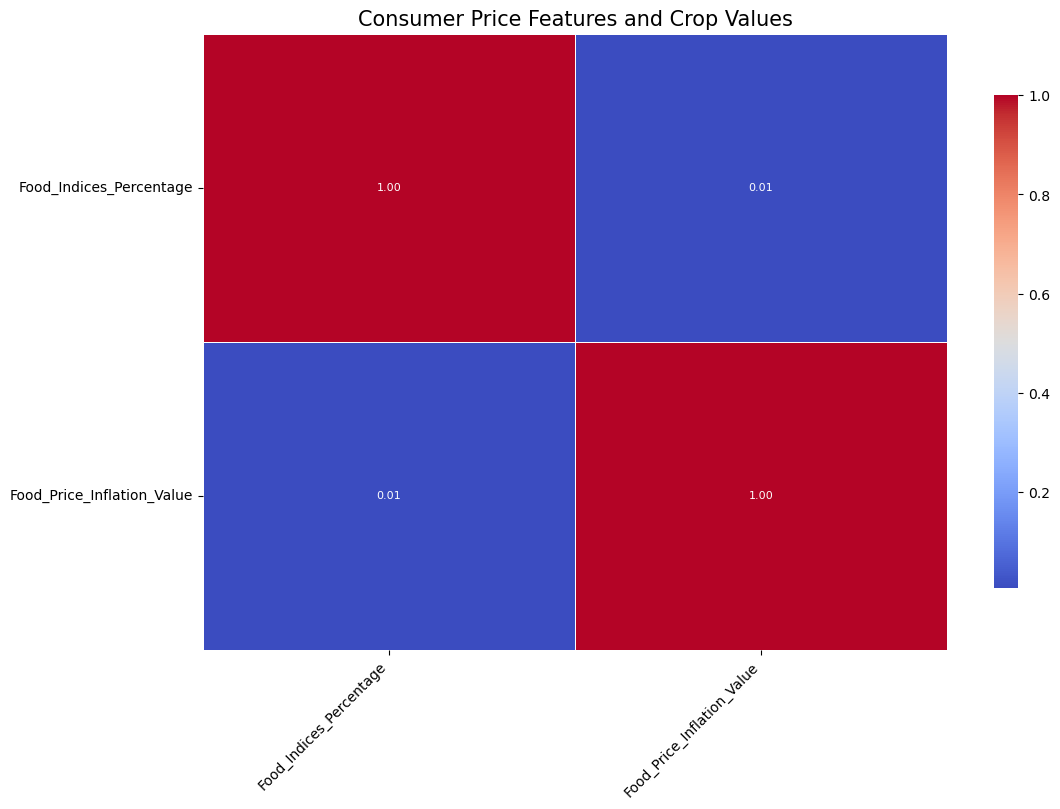

MSE: 102685292334427.2


,Feature,Importance
1,Food_Price_Inflation_Value,1.00
0,Food_Indices_Percentage,0.00


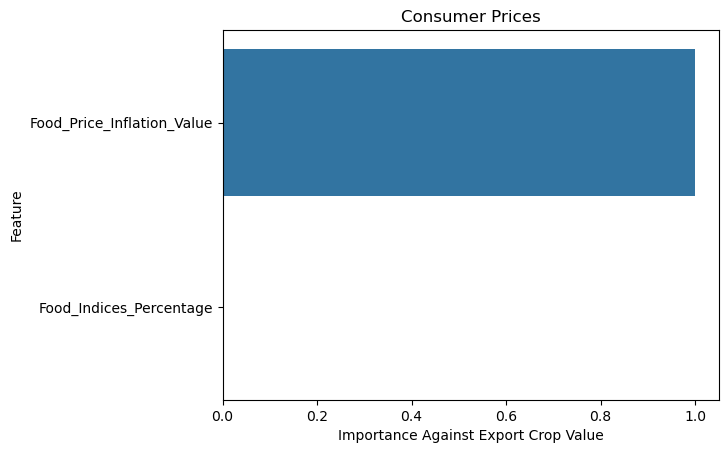

In [7]:
food_index_prices = consumer_prices[consumer_prices['Item'] == unique_items[0]]
food_index_prices = food_index_prices.rename(columns={'Value': 'Food_Indices_Value', 'Item': 'Food_Index_Item'})

price_inflation = consumer_prices[consumer_prices['Item'] == unique_items[1]]
price_inflation = price_inflation.rename(columns={'Value': 'Food_Price_Inflation_Value', 'Item': 'Inflation_Item'})

# normalise units by converting index values into percentages
# base year is 2015 (2015 = 100)
base_year = 2015
# get base year values
base_values = food_index_prices[food_index_prices['Year'] == base_year][['Area', 'Food_Indices_Value']].rename(columns={'Food_Indices_Value': 'Base_Year_Value'})
food_index_prices = pd.merge(food_index_prices, base_values, on='Area')
# calculate percentage change with respect to base year
food_index_prices['Food_Indices_Percentage'] = (food_index_prices['Food_Indices_Value'] / food_index_prices['Base_Year_Value'] - 1) * 100
food_index_prices = food_index_prices.drop(columns=['Food_Indices_Value', 'Base_Year_Value'])

cpi_df = pd.merge(price_inflation, food_index_prices, on=['Area', 'Year'])
cpi_df = pd.merge(cpi_df, crop_exports_summed[['Year', 'Area', 'Annual_Crop_Export_Value']], on=['Area', 'Year'])

# normalise
value_cols = ['Food_Indices_Percentage', 'Food_Price_Inflation_Value']
exchange_scaler = StandardScaler()
cpi_df[value_cols] = exchange_scaler.fit_transform(cpi_df[value_cols])
# save scaler to un-normalise later
joblib.dump(exchange_scaler, 'Scalers/exchange_scaler.pkl')

# find linear correlation between features and crop export values
correlation_export_crop_yield = cpi_df[value_cols].corr()
display_heatmap(correlation_export_crop_yield, title='Consumer Price Features and Crop Values')

# find non-linear correlation between features and crop export values
X = cpi_df[['Food_Indices_Percentage', 'Food_Price_Inflation_Value']]
y = cpi_df['Annual_Crop_Export_Value']
rank_feature_importance(X, y, 'Consumer Prices')

### crops_production_indicators.csv


In [8]:
production_indicators = pd.read_csv('Data/raw_data/crops_production_indicators.csv')
production_indicators = production_indicators.drop(columns=['Domain Code', 'Domain', 
                                                            'Area Code (M49)', 'Element Code', 
                                                            'Element', 'Item Code (CPC)', 
                                                            'Year Code', 'Unit', 
                                                            'Flag', 'Flag Description', 
                                                            'Note'])
production_indicators = production_indicators[(production_indicators['Year'] >= 2002) & (production_indicators['Year'] <= 2022)]

unique_items = production_indicators['Item'].unique()
print(f'Unique Items: {unique_items}')

Unique Items: ['Cereals, primary' 'Citrus Fruit, Total' 'Fibre Crops, Fibre Equivalent'
 'Fruit Primary' 'Oilcrops, Cake Equivalent' 'Oilcrops, Oil Equivalent'
 'Pulses, Total' 'Roots and Tubers, Total' 'Sugar Crops Primary'
 'Treenuts, Total' 'Vegetables Primary']


In [9]:
# sort all production indicators by product and save in separate dfs
cereals = production_indicators[production_indicators['Item'] == unique_items[0]].copy() # cereals and prep
citrus = production_indicators[production_indicators['Item'] == unique_items[1]].copy() # fruit and veg
materials = production_indicators[production_indicators['Item'] == unique_items[2]].copy() # non-food
fruit = production_indicators[production_indicators['Item'] == unique_items[3]].copy() # fruit and veg
oil_crops_cake = production_indicators[production_indicators['Item'] == unique_items[4]].copy() # fats and oils
oil_crops_oil = production_indicators[production_indicators['Item'] == unique_items[5]].copy() # fats and oils
pulses = production_indicators[production_indicators['Item'] == unique_items[6]].copy() # fruit and veg
sugars = production_indicators[production_indicators['Item'] == unique_items[7]].copy() # sugar and honey
roots_and_tubers = production_indicators[production_indicators['Item'] == unique_items[8]].copy() # fruit and veg
vegetables = production_indicators[production_indicators['Item'] == unique_items[10]].copy() # fruit and veg

In [10]:
# match Item descriptions to crop_exports_by_prod df
cereals.loc[:, 'Item'] = crop_products_dict['cereals']
materials.loc[:, 'Item'] = crop_products_dict['materials']
sugars.loc[:, 'Item'] = crop_products_dict['sugar']
oil_crops_cake.loc[:, 'Item'] = crop_products_dict['fats']
oil_crops_oil.loc[:, 'Item'] = crop_products_dict['fats']
citrus.loc[:, 'Item'] = crop_products_dict['fruit and veg']
fruit.loc[:, 'Item'] = crop_products_dict['fruit and veg']
pulses.loc[:, 'Item'] = crop_products_dict['fruit and veg']
roots_and_tubers.loc[:, 'Item'] = crop_products_dict['fruit and veg']
vegetables.loc[:, 'Item'] = crop_products_dict['fruit and veg']

# merge production indicators that are in the same category
fruit_and_veg = pd.concat([citrus, fruit, pulses, roots_and_tubers, vegetables])
fats = pd.concat([oil_crops_cake, oil_crops_oil])

fruit_and_veg = fruit_and_veg.groupby(['Area', 'Year', 'Item'], as_index=False)['Value'].sum()
fats = fats.groupby(['Area', 'Year', 'Item'], as_index=False)['Value'].sum()

In [11]:
# separate crop products into their own dfs
cereal_exports = crop_exports_by_prod[crop_exports_by_prod['Item'] == crop_products_dict['cereals']]
cereal_exports = cereal_exports.rename(columns={'Crop_Export_Value': 'Cereal_Export_Value'})

fruit_and_veg_exports = crop_exports_by_prod[crop_exports_by_prod['Item'] == crop_products_dict['fruit and veg']]
fruit_and_veg_exports = fruit_and_veg_exports.rename(columns={'Crop_Export_Value': 'Fruit_And_Veg_Export_Value'})

non_food_exports = crop_exports_by_prod[crop_exports_by_prod['Item'] == crop_products_dict['materials']]
non_food_exports = non_food_exports.rename(columns={'Crop_Export_Value': 'Non_Food_Export_Value'})

fats_exports = crop_exports_by_prod[crop_exports_by_prod['Item'] == crop_products_dict['fats']]
fats_exports = fats_exports.rename(columns={'Crop_Export_Value': 'Fats_Export_Value'})

sugars_exports = crop_exports_by_prod[crop_exports_by_prod['Item'] == crop_products_dict['sugar']]
sugars_exports = sugars_exports.rename(columns={'Crop_Export_Value': 'Sugars_Export_Value'})

In [12]:
cereals = cereals.rename(columns={'Value': 'Cereals_Value'})
materials = materials.rename(columns={'Value': 'Materials_Value'})
sugars = sugars.rename(columns={'Value': 'Sugars_Value'})
fats = fats.rename(columns={'Value': 'Fats_Value'})
fruit_and_veg = fruit_and_veg.rename(columns={'Value': 'Fruit_And_Veg_Value'})

/var/folders/r7/pmx4mq9n359ff5rbmwjtfsqh0000gn/T/ipykernel_7568/1848806999.py:3: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Item_x'} in the result is deprecated and will raise a MergeError in a future version.
  prod_indicators_df = pd.merge(prod_indicators_df, fats, on=['Area', 'Year'])


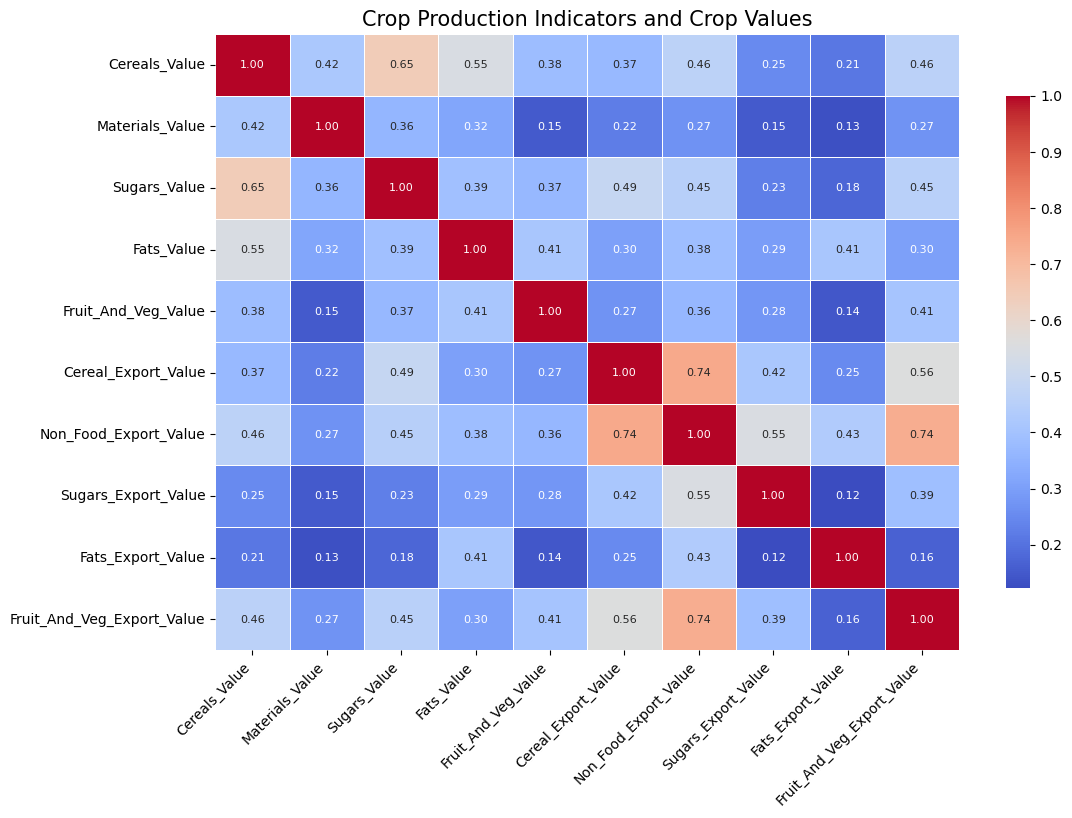

MSE: 18474596411290.49


,Feature,Importance
2,Sugars_Value,0.39
4,Fruit_And_Veg_Value,0.24
3,Fats_Value,0.15
1,Materials_Value,0.13
0,Cereals_Value,0.09


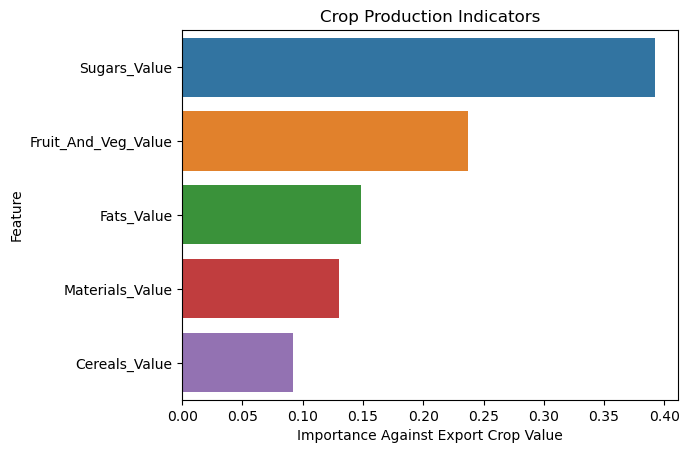

In [13]:
prod_indicators_df = pd.merge(cereals, materials, on=['Area', 'Year'])
prod_indicators_df = pd.merge(prod_indicators_df, sugars, on=['Area', 'Year'])
prod_indicators_df = pd.merge(prod_indicators_df, fats, on=['Area', 'Year'])
prod_indicators_df = pd.merge(prod_indicators_df, fruit_and_veg, on=['Area', 'Year'])
prod_indicators_df = pd.merge(prod_indicators_df, cereal_exports[['Area', 'Year', 'Cereal_Export_Value']], on=['Area', 'Year'])
prod_indicators_df = pd.merge(prod_indicators_df, non_food_exports[['Area', 'Year', 'Non_Food_Export_Value']], on=['Area', 'Year'])
prod_indicators_df = pd.merge(prod_indicators_df, sugars_exports[['Area', 'Year', 'Sugars_Export_Value']], on=['Area', 'Year'])
prod_indicators_df = pd.merge(prod_indicators_df, fats_exports[['Area', 'Year', 'Fats_Export_Value']], on=['Area', 'Year'])
prod_indicators_df = pd.merge(prod_indicators_df, fruit_and_veg_exports[['Area', 'Year', 'Fruit_And_Veg_Export_Value']], on=['Area', 'Year'])
prod_indicators_df = pd.merge(prod_indicators_df, crop_exports_summed[['Year', 'Area', 'Annual_Crop_Export_Value']], on=['Area', 'Year'])

# normalise
value_cols = ['Cereals_Value', 'Materials_Value', 'Sugars_Value', 'Fats_Value',
              'Fruit_And_Veg_Value', 'Cereal_Export_Value', 'Non_Food_Export_Value',
              'Sugars_Export_Value',  'Fats_Export_Value', 'Fruit_And_Veg_Export_Value']
prod_indicators_scaler = StandardScaler()
prod_indicators_df[value_cols] = prod_indicators_scaler.fit_transform(prod_indicators_df[value_cols])
joblib.dump(prod_indicators_scaler, 'Scalers/prod_indicators_scaler.pkl')

# find linear correlation between features and crop export values
correlation = prod_indicators_df[value_cols].corr()
display_heatmap(correlation, title='Crop Production Indicators and Crop Values')

# find non-linear correlation between features and crop export values
X = prod_indicators_df[['Cereals_Value', 'Materials_Value', 'Sugars_Value', 'Fats_Value','Fruit_And_Veg_Value']]
y = prod_indicators_df['Annual_Crop_Export_Value']
rank_feature_importance(X, y, 'Crop Production Indicators')

### emissions.csv

In [14]:
emissions = pd.read_csv('Data/raw_data/emissions.csv')
emissions = emissions.drop(columns=['Domain Code', 'Domain', 
                                                            'Area Code (M49)', 'Element Code', 
                                                            'Item Code (CPC)', 'Year Code', 
                                                            'Unit', 'Flag', 
                                                            'Flag Description', 'Note', 
                                                            'Source Code', 'Source'])
emissions = emissions[(emissions['Year'] >= 2002) & (emissions['Year'] <= 2022)]

unique_items = emissions['Item'].unique()
print(f'Unique Items: {unique_items}')

Unique Items: ['All Crops' 'Cropland organic soils' 'Grassland organic soils']


In [15]:
crop_emissions = emissions[emissions['Item'] == unique_items[0]].copy()
unique_elements = crop_emissions['Element'].unique()
print(f'Unique Elements: {unique_elements}')

Unique Elements: ['Crops total (Emissions N2O)' 'Crops total (Emissions CH4)']


In [16]:
n20_emissions = crop_emissions[crop_emissions['Element'] == unique_elements[0]].copy()
ch4_emissions = crop_emissions[crop_emissions['Element'] == unique_elements[1]].copy()
n20_emissions = n20_emissions.rename(columns={'Value': 'N20_Emissions_Value'})
ch4_emissions = ch4_emissions.rename(columns={'Value': 'CH4_Emissions_Value'})

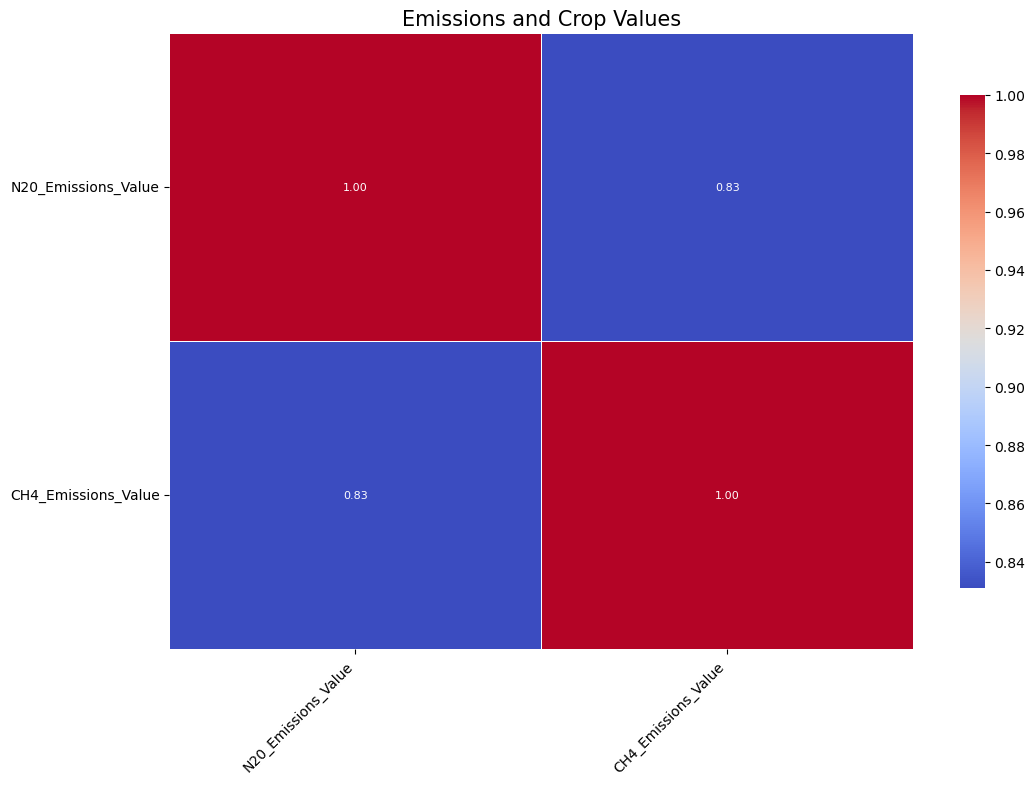

MSE: 15156346809682.2


,Feature,Importance
0,N20_Emissions_Value,0.66
1,CH4_Emissions_Value,0.34


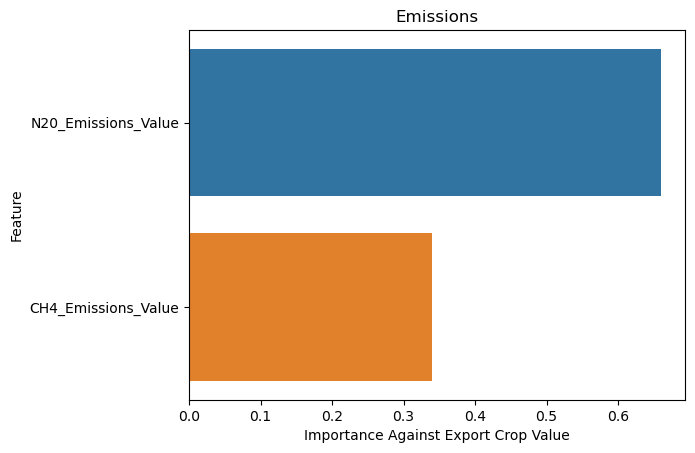

In [17]:
emissions_df = pd.merge(n20_emissions, ch4_emissions, on=['Area', 'Year'])
emissions_df = pd.merge(emissions_df, crop_exports_summed[['Year', 'Area', 'Annual_Crop_Export_Value']], on=['Area', 'Year'])

# normalise
value_cols = ['N20_Emissions_Value', 'CH4_Emissions_Value']
emissions_scaler = StandardScaler()
emissions_df[value_cols] = emissions_scaler.fit_transform(emissions_df[value_cols])
joblib.dump(emissions_scaler, 'Scalers/emissions_scaler.pkl')

# find linear correlation between features and crop export values
correlation = emissions_df[value_cols].corr()
display_heatmap(correlation, title='Emissions and Crop Values')

# find non-linear correlation between features and crop export values
X = emissions_df[['N20_Emissions_Value', 'CH4_Emissions_Value']]
y = emissions_df['Annual_Crop_Export_Value']
rank_feature_importance(X, y, 'Emissions')

### employment_data.csv

In [18]:
employment_data = pd.read_csv('Data/raw_data/employment_data.csv')

employment_data = employment_data.drop(columns=['Domain Code', 'Domain', 
                                                'Area Code (M49)', 'Indicator Code',
                                                'Sex Code', 'Sex', 'Year Code',
                                                'Element Code', 'Element', 'Source Code',
                                                'Flag', 'Flag Description', 'Note', 'Source', 'Unit'])
employment_data = employment_data[(employment_data['Year'] >= 2002) & (employment_data['Year'] <= 2022)]

unique_indicators = employment_data['Indicator'].unique()
print(f'Unique Indicators: {unique_items}')

Unique Indicators: ['All Crops' 'Cropland organic soils' 'Grassland organic soils']


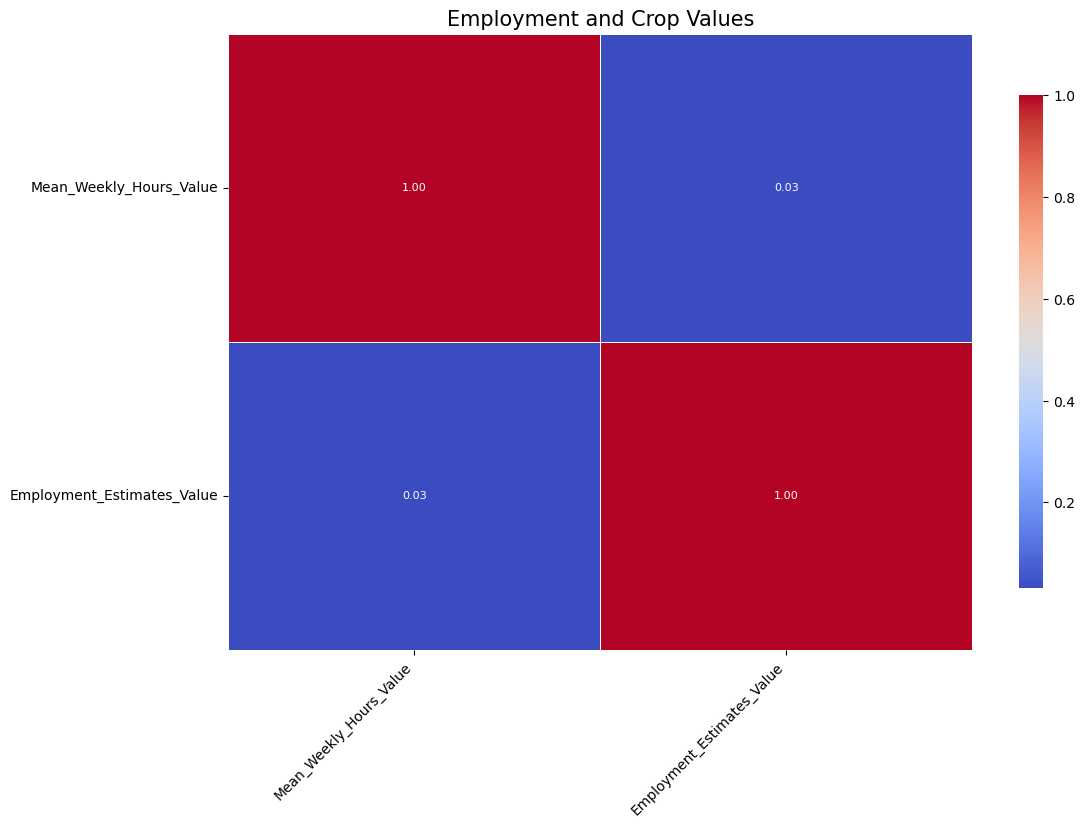

MSE: 67325166434195.49


,Feature,Importance
1,Employment_Estimates_Value,0.66
0,Mean_Weekly_Hours_Value,0.34


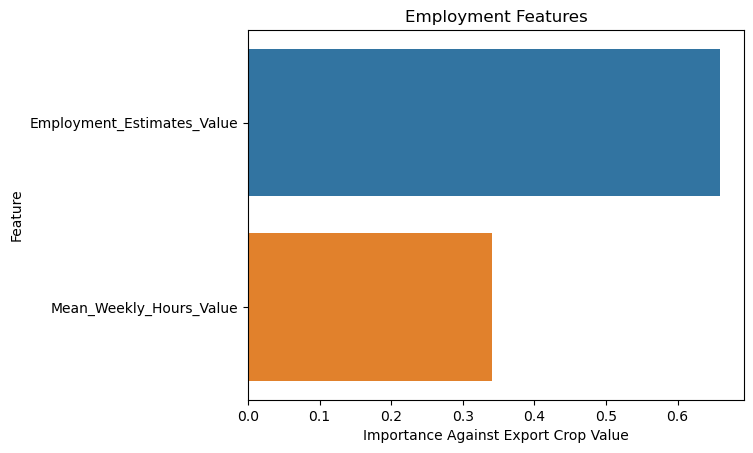

In [19]:
weekly_hours = employment_data[employment_data['Indicator'] == unique_indicators[0]]
weekly_hours = weekly_hours.rename(columns={'Value': 'Mean_Weekly_Hours_Value'})

employment_estimates = employment_data[employment_data['Indicator'] == unique_indicators[1]]
employment_estimates = employment_estimates.rename(columns={'Value': 'Employment_Estimates_Value'})

employment_df = pd.merge(weekly_hours, employment_estimates, on=['Area', 'Year'])
employment_df = pd.merge(employment_df, crop_exports_summed[['Area', 'Year', 'Annual_Crop_Export_Value']], on=['Area', 'Year'])

# normalise
value_cols = ['Mean_Weekly_Hours_Value', 'Employment_Estimates_Value']
employment_scaler = StandardScaler()
employment_df[value_cols] = employment_scaler.fit_transform(employment_df[value_cols])
joblib.dump(employment_scaler, 'Scalers/employment_scaler.pkl')

# find linear correlation between features and crop export values
correlation = employment_df[value_cols].corr()
display_heatmap(correlation, title='Employment and Crop Values')

# find non-linear correlation between features and crop export values
X = employment_df[['Mean_Weekly_Hours_Value', 'Employment_Estimates_Value']]
y = employment_df['Annual_Crop_Export_Value']
rank_feature_importance(X, y, 'Employment Features')


### exchange_rate.csv

In [20]:
exchange_rates = pd.read_csv('Data/raw_data/exchange_rate.csv')
# change monthly data to annual data
exchange_rates = exchange_rates.groupby(['Year', 'Area'])['Value'].mean().reset_index()
exchange_rates = exchange_rates[(exchange_rates['Year'] >= 2002) & (exchange_rates['Year'] <= 2022)]

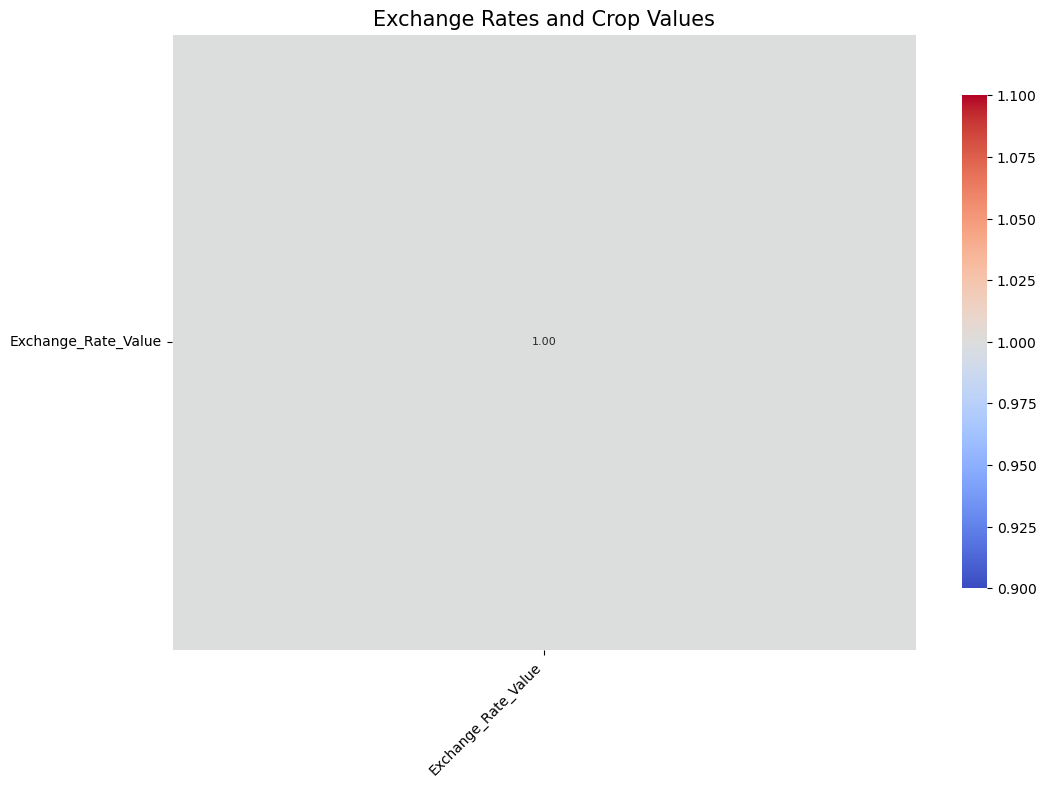

MSE: 96783661020227.06


,Feature,Importance
0,Exchange_Rate_Value,1.00


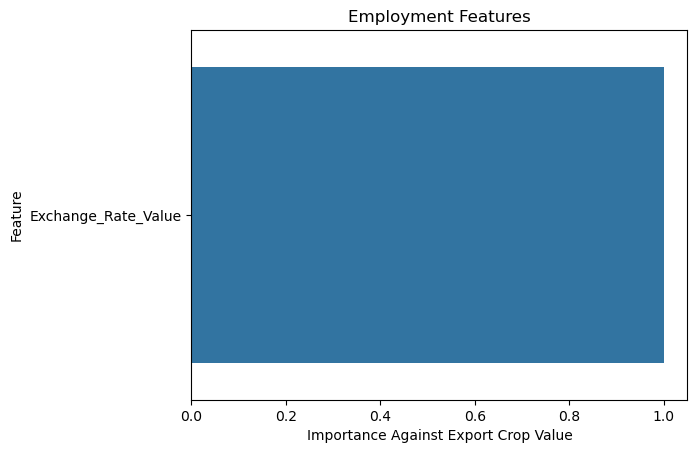

In [21]:
exchange_rates = exchange_rates.rename(columns={'Value': 'Exchange_Rate_Value'})
exchange_rates_df = pd.merge(exchange_rates, crop_exports_summed[['Area', 'Year', 'Annual_Crop_Export_Value']], on=['Year', 'Area'])

# normalise
value_cols = ['Exchange_Rate_Value']
value_scaler = StandardScaler()
exchange_rates_df[value_cols] = value_scaler.fit_transform(exchange_rates_df[value_cols])
joblib.dump(value_scaler, 'Scalers/value_scaler.pkl')

# find linear correlation between features and crop export values
correlation = exchange_rates_df[value_cols].corr()
display_heatmap(correlation, title='Exchange Rates and Crop Values')

# find non-linear correlation between features and crop export values
X = exchange_rates_df['Exchange_Rate_Value'].values.reshape(-1, 1)
y = exchange_rates_df['Annual_Crop_Export_Value']
rank_feature_importance(X, y, 'Employment Features', 'Exchange_Rate_Value')

### fertilizers.csv

In [22]:
fertilisers = pd.read_csv('Data/raw_data/fertilizers.csv')
fertilisers = fertilisers.drop(columns=['Domain Code', 'Domain', 'Area Code (M49)', 'Element Code',
                                        'Element', 'Item Code', 'Year Code',
                                        'Unit', 'Flag', 'Flag Description'])
fertilisers = fertilisers[(fertilisers['Year'] >= 2002) & (fertilisers['Year'] <= 2022)]

unique_items = fertilisers['Item'].unique()
print(f'Unique Items: {unique_items}')

Unique Items: ['NPK fertilizers' 'Urea' 'Ammonium nitrate (AN)' 'Ammonium sulphate'
 'Calcium ammonium nitrate (CAN) and other mixtures with calcium carbonate'
 'Diammonium phosphate (DAP)' 'Monoammonium phosphate (MAP)'
 'Other NP compounds' 'PK compounds'
 'Potassium chloride (muriate of potash) (MOP)' 'Potassium nitrate'
 'Potassium sulphate (sulphate of potash) (SOP)' 'Sodium nitrate'
 'Superphosphates above 35%' 'Superphosphates, other' 'Ammonia, anhydrous'
 'Phosphate rock' 'Urea and ammonium nitrate solutions (UAN)'
 'Fertilizers n.e.c.' 'Other nitrogenous fertilizers, n.e.c.'
 'Other phosphatic fertilizers, n.e.c.'
 'Other potassic fertilizers, n.e.c.' 'Other NK compounds']


In [23]:
npk = fertilisers[fertilisers['Item'] == unique_items[0]].copy()
npk = npk.rename(columns={'Value': 'NPK_Value', 'Item': 'NPK_Item'})

urea = fertilisers[fertilisers['Item'] == unique_items[1]].copy()
urea = urea.rename(columns={'Value': 'Urea_Value', 'Item': 'Urea_Item'})

an = fertilisers[fertilisers['Item'] == unique_items[2]].copy()
an = an.rename(columns={'Value': 'Ammonium_Nitrate_Value', 'Item': 'AN_Item'})

amm_sulphate = fertilisers[fertilisers['Item'] == unique_items[3]].copy()
amm_sulphate = amm_sulphate.rename(columns={'Value': 'Ammonium_Sulphate_Value', 
                                            'Item': 'Ammonium_Sulphate_Item'})

can = fertilisers[fertilisers['Item'] == unique_items[4]].copy()
can = can.rename(columns={'Value': 'CAN_Value', 'Item': 'CAN_Item'})


dap = fertilisers[fertilisers['Item'] == unique_items[5]].copy()
dap = dap.rename(columns={'Value': 'DAP_Value', 'Item': 'DAP_Item'})

map = fertilisers[fertilisers['Item'] == unique_items[6]].copy()
map = map.rename(columns={'Value': 'MAP_Value', 'Item': 'MAP_Item'})

other_np = fertilisers[fertilisers['Item'] == unique_items[7]].copy()
other_np = other_np.rename(columns={'Value': 'Other_NP_Compounds_Value', 
                                    'Item': 'Other_NP_Compounds_Item'})

pk_compounds = fertilisers[fertilisers['Item'] == unique_items[8]].copy()
pk_compounds = pk_compounds.rename(columns={'Value': 'PK_Compounds_Value', 
                                            'Item': 'PK_Compounds_Item'})

mop = fertilisers[fertilisers['Item'] == unique_items[9]].copy()
mop = mop.rename(columns={'Value': 'MOP_Value', 'Item': 'MOP_Item'})

pot_nitrate = fertilisers[fertilisers['Item'] == unique_items[10]].copy()
pot_nitrate = pot_nitrate.rename(columns={'Value': 'Potassium_Nitrate_Value', 
                                          'Item': 'Potassium_Nitrate_Item'})

sop = fertilisers[fertilisers['Item'] == unique_items[11]].copy()
sop = sop.rename(columns={'Value': 'SOP_Value', 'Item': 'SOP_Item'})

sod_nitrate = fertilisers[fertilisers['Item'] == unique_items[12]].copy()
sod_nitrate = sod_nitrate.rename(columns={'Value': 'Sodium_Nitrate_Value', 
                                          'Item': 'Sodium_Nitrate_Item'})

superphosphates_35 = fertilisers[fertilisers['Item'] == unique_items[13]].copy()
superphosphates_35 = superphosphates_35.rename(columns={'Value': 'Superphosphates_Above_35%_Value', 
                                                        'Item': 'Superphosphates_Above_35%_Item'})

superphosphates_other = fertilisers[fertilisers['Item'] == unique_items[14]].copy()
superphosphates_other = superphosphates_other.rename(columns={'Value': 'Superphosphates_Other_Value', 
                                                              'Item': 'Superphosphates_Other_Item'})

amm_anyhyrous = fertilisers[fertilisers['Item'] == unique_items[15]].copy()
amm_anyhyrous = amm_anyhyrous.rename(columns={'Value': 'Ammonia_Anhydrous_Value', 
                                              'Item': 'Ammonia_Anhydrous_Item'})

phos_rock = fertilisers[fertilisers['Item'] == unique_items[16]].copy()
phos_rock = phos_rock.rename(columns={'Value': 'Phosphate_Rock_Value', 
                                      'Item': 'Phosphate_Rock_Item'})

uan = fertilisers[fertilisers['Item'] == unique_items[17]].copy()
uan = uan.rename(columns={'Value': 'UAN_Value', 'Item': 'UAN_Item'})

nec = fertilisers[fertilisers['Item'] == unique_items[18]].copy()
nec = nec.rename(columns={'Value': 'Fertilisers_NEC_Value', 'Item': 'Fertilisers_NEC_Item'})

other_nit_nec = fertilisers[fertilisers['Item'] == unique_items[19]].copy()
other_nit_nec = other_nit_nec.rename(columns={'Value': 'Other_Nitrogenous_Value', 
                                              'Item': 'Other_Nitrogenous_Item'})

other_phos_nec = fertilisers[fertilisers['Item'] == unique_items[20]].copy()
other_phos_nec = other_phos_nec.rename(columns={'Value': 'Other_Phosphatic_Value', 
                                                'Item': 'Other_Phosphatic_Item'})

other_pots_nec = fertilisers[fertilisers['Item'] == unique_items[21]].copy()
other_pots_nec = other_pots_nec.rename(columns={'Value': 'Other_Potassic_Value', 
                                                'Item': 'Other_Potassic_Item'})

other_nk = fertilisers[fertilisers['Item'] == unique_items[22]].copy()
other_nk = other_nk.rename(columns={'Value': 'Other_NK_Value', 
                                    'Item': 'Other_NK_Item'})

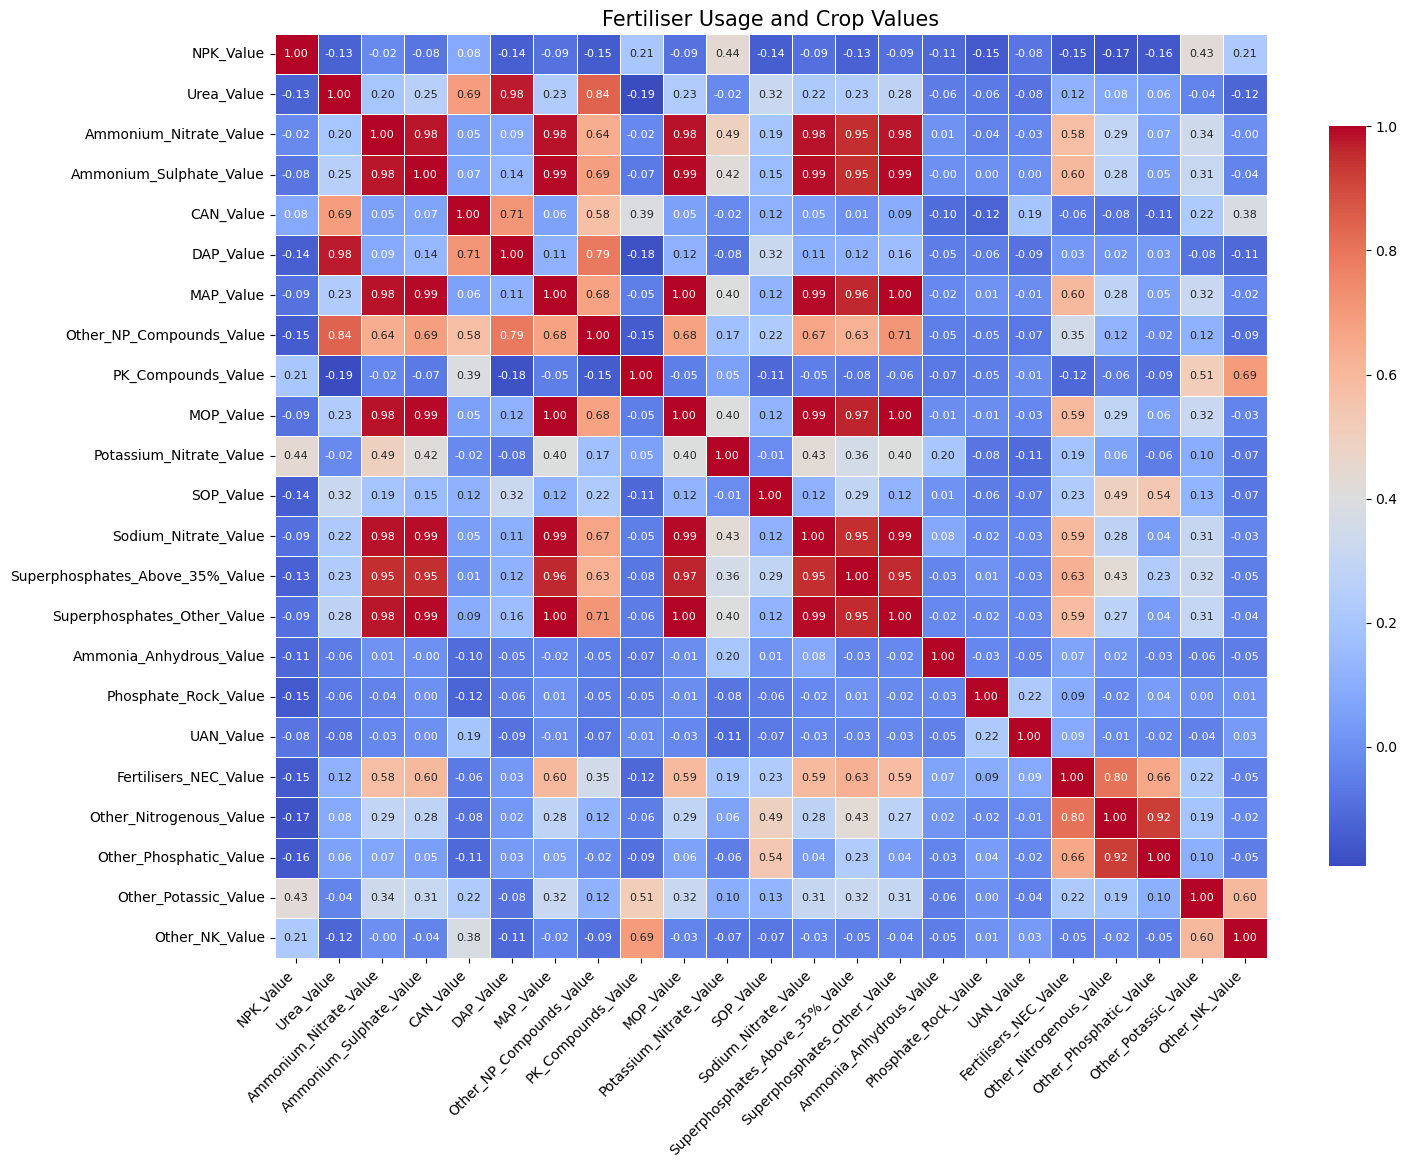

MSE: 811575275692.2638


,Feature,Importance
3,Ammonium_Sulphate_Value,0.19
11,SOP_Value,0.18
4,CAN_Value,0.17
10,Potassium_Nitrate_Value,0.09
1,Urea_Value,0.07
14,Superphosphates_Other_Value,0.06
13,Superphosphates_Above_35%_Value,0.04
9,MOP_Value,0.04
19,Other_Nitrogenous_Value,0.04
5,DAP_Value,0.04


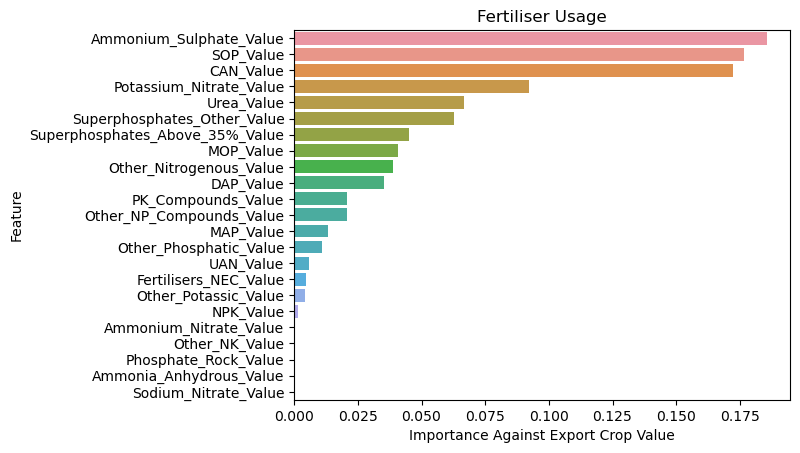

In [24]:
fertilisers_df = pd.merge(npk, urea, on=['Area', 'Year'])
fertilisers_df = pd.merge(fertilisers_df, an, on=['Area', 'Year'])
fertilisers_df = pd.merge(fertilisers_df, amm_sulphate, on=['Area', 'Year'])
fertilisers_df = pd.merge(fertilisers_df, can, on=['Area', 'Year'])
fertilisers_df = pd.merge(fertilisers_df, dap, on=['Area', 'Year'])
fertilisers_df = pd.merge(fertilisers_df, map, on=['Area', 'Year'])
fertilisers_df = pd.merge(fertilisers_df, other_np, on=['Area', 'Year'])
fertilisers_df = pd.merge(fertilisers_df, pk_compounds, on=['Area', 'Year'])
fertilisers_df = pd.merge(fertilisers_df, mop, on=['Area', 'Year'])
fertilisers_df = pd.merge(fertilisers_df, pot_nitrate, on=['Area', 'Year'])
fertilisers_df = pd.merge(fertilisers_df, sop, on=['Area', 'Year'])
fertilisers_df = pd.merge(fertilisers_df, sod_nitrate, on=['Area', 'Year'])
fertilisers_df = pd.merge(fertilisers_df, superphosphates_35, on=['Area', 'Year'])
fertilisers_df = pd.merge(fertilisers_df, superphosphates_other, on=['Area', 'Year'])
fertilisers_df = pd.merge(fertilisers_df, amm_anyhyrous, on=['Area', 'Year'])
fertilisers_df = pd.merge(fertilisers_df, phos_rock, on=['Area', 'Year'])
fertilisers_df = pd.merge(fertilisers_df, uan, on=['Area', 'Year'])
fertilisers_df = pd.merge(fertilisers_df, nec, on=['Area', 'Year'])
fertilisers_df = pd.merge(fertilisers_df, other_nit_nec, on=['Area', 'Year'])
fertilisers_df = pd.merge(fertilisers_df, other_phos_nec, on=['Area', 'Year'])
fertilisers_df = pd.merge(fertilisers_df, other_pots_nec, on=['Area', 'Year'])
fertilisers_df = pd.merge(fertilisers_df, other_nk, on=['Area', 'Year'])
fertilisers_df = pd.merge(fertilisers_df, crop_exports_summed[['Area', 'Year', 'Annual_Crop_Export_Value']], on=['Area', 'Year'])

# normalise
value_cols = ['NPK_Value', 'Urea_Value', 'Ammonium_Nitrate_Value', 
                'Ammonium_Sulphate_Value', 'CAN_Value', 'DAP_Value',
                'MAP_Value', 'Other_NP_Compounds_Value', 'PK_Compounds_Value',
                'MOP_Value', 'Potassium_Nitrate_Value', 'SOP_Value',
                'Sodium_Nitrate_Value', 'Superphosphates_Above_35%_Value', 'Superphosphates_Other_Value',
                'Ammonia_Anhydrous_Value', 'Phosphate_Rock_Value', 'UAN_Value',
                'Fertilisers_NEC_Value', 'Other_Nitrogenous_Value', 'Other_Phosphatic_Value',
                'Other_Potassic_Value', 'Other_NK_Value']

fertilisers_scaler = StandardScaler()
fertilisers_df[value_cols] = fertilisers_scaler.fit_transform(fertilisers_df[value_cols])
joblib.dump(fertilisers_scaler, 'Scalers/fertilisers_scaler.pkl')

# find linear correlation between features and crop export values
correlation = fertilisers_df[value_cols].corr()
display_heatmap(correlation, title='Fertiliser Usage and Crop Values', figsize=(16, 12))

# find non-linear correlation between features and crop export values
X = fertilisers_df[['NPK_Value', 'Urea_Value', 'Ammonium_Nitrate_Value', 
                'Ammonium_Sulphate_Value', 'CAN_Value', 'DAP_Value',
                'MAP_Value', 'Other_NP_Compounds_Value', 'PK_Compounds_Value',
                'MOP_Value', 'Potassium_Nitrate_Value', 'SOP_Value',
                'Sodium_Nitrate_Value', 'Superphosphates_Above_35%_Value', 'Superphosphates_Other_Value',
                'Ammonia_Anhydrous_Value', 'Phosphate_Rock_Value', 'UAN_Value',
                'Fertilisers_NEC_Value', 'Other_Nitrogenous_Value', 'Other_Phosphatic_Value',
                'Other_Potassic_Value', 'Other_NK_Value']]
y = fertilisers_df['Annual_Crop_Export_Value']
rank_feature_importance(X, y, 'Fertiliser Usage')

### food_balance_indicators.csv

In [25]:
balance_indicators = pd.read_csv('Data/raw_data/food_balance_indicators.csv')
balance_indicators = balance_indicators.drop(columns=['Domain Code', 'Domain', 
                                                      'Area Code (M49)', 'Element Code', 
                                                      'Item Code (FBS)', 'Year Code', 
                                                      'Unit', 'Flag', 'Flag Description'])
balance_indicators = balance_indicators[(balance_indicators['Year'] >= 2002) & (balance_indicators['Year'] <= 2022)]

unique_items = balance_indicators['Item'].unique()
print(f'Unique Items: {unique_items}\n')

unique_elements = balance_indicators['Element'].unique()
print(f'Elements: {unique_elements}')

Unique Items: ['Cereals - Excluding Beer' 'Starchy Roots' 'Sugar Crops'
 'Sugar & Sweeteners' 'Pulses' 'Treenuts' 'Oilcrops' 'Vegetable Oils'
 'Vegetables' 'Fruits - Excluding Wine' 'Stimulants' 'Spices'
 'Alcoholic Beverages' 'Meat' 'Eggs' 'Milk - Excluding Butter'
 'Fish, Seafood']

Elements: ['Import Quantity' 'Export Quantity' 'Losses' 'Other uses (non-food)'
 'Food']


In [26]:
cereals = balance_indicators[balance_indicators['Item'] == unique_items[0]].copy()
roots = balance_indicators[balance_indicators['Item'] == unique_items[1]].copy()
sugars = balance_indicators[balance_indicators['Item'] == unique_items[2]].copy()
pulses = balance_indicators[balance_indicators['Item'] == unique_items[4]].copy()
oil_crops = balance_indicators[balance_indicators['Item'] == unique_items[6]].copy()
vegetable_oils = balance_indicators[balance_indicators['Item'] == unique_items[7]].copy()
vegetables = balance_indicators[balance_indicators['Item'] == unique_items[8]].copy()
fruits = balance_indicators[balance_indicators['Item'] == unique_items[9]].copy()
alcohol = balance_indicators[balance_indicators['Item'] == unique_items[12]].copy()

In [27]:
cereal_imports = cereals[cereals['Element'] == unique_elements[0]].copy()
cereal_exports = cereals[cereals['Element'] == unique_elements[1]].copy()
cereal_losses = cereals[cereals['Element'] == unique_elements[2]].copy()
cereal_other = cereals[cereals['Element'] == unique_elements[3]].copy()
cereal_food = cereals[cereals['Element'] == unique_elements[4]].copy()
cereal_imports = cereal_imports.rename(columns={'Value': 'Cereal_Imports_Value', 
                                                'Element': 'Cereal_Imports_Element',
                                                'Item': 'Cereal_Imports_Item'})
cereal_exports = cereal_exports.rename(columns={'Value': 'Cereal_Exports_Value', 
                                                'Element': 'Cereal_Exports_Element',
                                                'Item': 'Cereal_Exports_Item'})
cereal_losses = cereal_losses.rename(columns={'Value': 'Cereal_Losses_Value', 
                                              'Element': 'Cereal_Losses_Element',
                                              'Item': 'Cereal_Losses_Item'})
cereal_other = cereal_other.rename(columns={'Value': 'Cereal_Other_Value', 
                                            'Element': 'Cereal_Other_Element',
                                            'Item': 'Cereal_Other_Item'})
cereal_food = cereal_food.rename(columns={'Value': 'Cereal_Food_Value', 
                                          'Element': 'Cereal_Food_Element',
                                          'Item': 'Cereal_Food_Item'})

roots_imports = roots[roots['Element'] == unique_elements[0]].copy()
roots_exports = roots[roots['Element'] == unique_elements[1]].copy()
roots_losses = roots[roots['Element'] == unique_elements[2]].copy()
roots_other = roots[roots['Element'] == unique_elements[3]].copy()
roots_food = roots[roots['Element'] == unique_elements[4]].copy()
roots_imports = roots_imports.rename(columns={'Value': 'Roots_Imports_Value', 
                                              'Element': 'Roots_Imports_Element',
                                              'Item': 'Roots_Imports_Item'})
roots_exports = roots_exports.rename(columns={'Value': 'Roots_Exports_Value', 
                                              'Element': 'Roots_Exports_Element',
                                              'Item': 'Roots_Exports_Item'})
roots_losses = roots_losses.rename(columns={'Value': 'Roots_Losses_Value', 
                                            'Element': 'Roots_Losses_Element',
                                            'Item': 'Roots_Losses_Item'})
roots_other = roots_other.rename(columns={'Value': 'Roots_Other_Value', 
                                          'Element': 'Roots_Other_Element',
                                          'Item': 'Roots_Other_Item'})
roots_food = roots_food.rename(columns={'Value': 'Roots_Food_Value', 
                                        'Element': 'Roots_Food_Element',
                                        'Item': 'Roots_Food_Item'})


sugars_imports = sugars[sugars['Element'] == unique_elements[0]].copy()
sugars_exports = sugars[sugars['Element'] == unique_elements[1]].copy()
sugars_losses = sugars[sugars['Element'] == unique_elements[2]].copy()
sugars_other = sugars[sugars['Element'] == unique_elements[3]].copy()
sugars_food = sugars[sugars['Element'] == unique_elements[4]].copy()
sugars_imports = sugars_imports.rename(columns={'Value': 'Sugars_Imports_Value', 
                                                'Element': 'Sugars_Imports_Element',
                                                'Item': 'Sugars_Imports_Item'})
sugars_exports = sugars_exports.rename(columns={'Value': 'Sugars_Exports_Value', 
                                                'Element': 'Sugars_Exports_Element',
                                                'Item': 'Sugars_Exports_Item'})
sugars_losses = sugars_losses.rename(columns={'Value': 'Sugars_Losses_Value', 
                                              'Element': 'Sugars_Losses_Element',
                                              'Item': 'Sugars_Losses_Item'})
sugars_other = sugars_other.rename(columns={'Value': 'Sugars_Other_Value', 
                                            'Element': 'Sugars_Other_Element',
                                            'Item': 'Sugars_Other_Item'})
sugars_food = sugars_food.rename(columns={'Value': 'Sugars_Food_Value', 
                                          'Element': 'Sugars_Food_Element',
                                          'Item': 'Sugars_Food_Item'})

pulses_imports = pulses[pulses['Element'] == unique_elements[0]].copy()
pulses_exports = pulses[pulses['Element'] == unique_elements[1]].copy()
pulses_losses = pulses[pulses['Element'] == unique_elements[2]].copy()
pulses_other = pulses[pulses['Element'] == unique_elements[3]].copy()
pulses_food = pulses[pulses['Element'] == unique_elements[4]].copy()
pulses_imports = pulses_imports.rename(columns={'Value': 'Pulses_Imports_Value', 
                                                'Element': 'Pulses_Imports_Element',
                                                'Item': 'Pulses_Import_Item'})
pulses_exports = pulses_exports.rename(columns={'Value': 'Pulses_Exports_Value', 
                                                'Element': 'Pulses_Exports_Element',
                                                'Item': 'Pulses_Exports_Item'})
pulses_losses = pulses_losses.rename(columns={'Value': 'Pulses_Losses_Value', 
                                              'Element': 'Pulses_Losses_Element',
                                              'Item': 'Pulses_Losses_Item'})
pulses_other = pulses_other.rename(columns={'Value': 'Pulses_Other_Value', 
                                            'Element': 'Pulses_Other_Element',
                                            'Item': 'Pulses_Other_Item'})
pulses_food = pulses_food.rename(columns={'Value': 'Pulses_Food_Value', 
                                          'Element': 'Pulses_Food_Element',
                                          'Item': 'Pulses_Food_Item'})

oil_crops_imports = oil_crops[oil_crops['Element'] == unique_elements[0]].copy()
oil_crops_exports = oil_crops[oil_crops['Element'] == unique_elements[1]].copy()
oil_crops_losses = oil_crops[oil_crops['Element'] == unique_elements[2]].copy()
oil_crops_other = oil_crops[oil_crops['Element'] == unique_elements[3]].copy()
oil_crops_food = oil_crops[oil_crops['Element'] == unique_elements[4]].copy()
oil_crops_imports = oil_crops_imports.rename(columns={'Value': 'Oil_Crops_Imports_Value', 
                                                      'Element': 'Oil_Crops_Imports_Element',
                                                      'Item': 'Oil_Crops_Import_Item'})
oil_crops_exports = oil_crops_exports.rename(columns={'Value': 'Oil_Crops_Exports_Value', 
                                                      'Element': 'Oil_Crops_Exports_Element',
                                                      'Item': 'Oil_Crops_Exports_Item'})
oil_crops_losses = oil_crops_losses.rename(columns={'Value': 'Oil_Crops_Losses_Value', 
                                                    'Element': 'Oil_Crops_Losses_Element',
                                                    'Item': 'Oil_Crops_Losses_Item'})
oil_crops_other = oil_crops_other.rename(columns={'Value': 'Oil_Crops_Other_Value', 
                                                  'Element': 'Oil_Crops_Other_Element',
                                                  'Item': 'Oil_Crops_Other_Item'})
oil_crops_food = oil_crops_food.rename(columns={'Value': 'Oil_Crops_Food_Value', 
                                                'Element': 'Oil_Crops_Food_Element',
                                                'Item': 'Oil_Crops_Food_Item'})

vegetable_oils_imports = vegetable_oils[vegetable_oils['Element'] == unique_elements[0]].copy()
vegetable_oils_exports = vegetable_oils[vegetable_oils['Element'] == unique_elements[1]].copy()
vegetable_oils_losses = vegetable_oils[vegetable_oils['Element'] == unique_elements[2]].copy()
vegetable_oils_other = vegetable_oils[vegetable_oils['Element'] == unique_elements[3]].copy()
vegetable_oils_food = vegetable_oils[vegetable_oils['Element'] == unique_elements[4]].copy()
vegetable_oils_imports = vegetable_oils_imports.rename(columns={'Value': 'Vegetable_Oils_Imports_Value', 
                                                                'Element': 'Vegetable_Oils_Imports_Element',
                                                                'Item': 'Vegetable_Oils_Imports_Item'})
vegetable_oils_exports = vegetable_oils_exports.rename(columns={'Value': 'Vegetable_Oils_Exports_Value', 
                                                                'Element': 'Vegetable_Oils_Exports_Element',
                                                                'Item': 'Vegetable_Oils_Exports_Item'})
vegetable_oils_losses = vegetable_oils_losses.rename(columns={'Value': 'Vegetable_Oils_Losses_Value', 
                                                              'Element': 'Vegetable_Oils_Losses_Element',
                                                              'Item': 'Vegetable_Oils_Losses_Item'})
vegetable_oils_other = vegetable_oils_other.rename(columns={'Value': 'Vegetable_Oils_Other_Value', 
                                                            'Element': 'Vegetable_Oils_Other_Element',
                                                            'Item': 'Vegetable_Oils_Other_Item'})
vegetable_oils_food = vegetable_oils_food.rename(columns={'Value': 'Vegetable_Oils_Food_Value', 
                                                          'Element': 'Vegetable_Oils_Food_Element',
                                                          'Item': 'Vegetable_Oils_Food_Item'})

vegetables_imports = vegetables[vegetables['Element'] == unique_elements[0]].copy()
vegetables_exports = vegetables[vegetables['Element'] == unique_elements[1]].copy()
vegetables_losses = vegetables[vegetables['Element'] == unique_elements[2]].copy()
vegetables_other = vegetables[vegetables['Element'] == unique_elements[3]].copy()
vegetables_food = vegetables[vegetables['Element'] == unique_elements[4]].copy()
vegetables_imports = vegetables_imports.rename(columns={'Value': 'Vegetables_Imports_Value', 
                                                        'Element': 'Vegetables_Imports_Element',
                                                        'Item': 'Vegetables_Imports_Item'})
vegetables_exports = vegetables_exports.rename(columns={'Value': 'Vegetables_Exports_Value', 
                                                        'Element': 'Vegetables_Exports_Element',
                                                        'Item': 'Vegetables_Exports_Item'})
vegetables_losses = vegetables_losses.rename(columns={'Value': 'Vegetables_Losses_Value', 
                                                      'Element': 'Vegetables_Losses_Element',
                                                      'Item': 'Vegetables_Losses_Item'})
vegetables_other = vegetables_other.rename(columns={'Value': 'Vegetables_Other_Value', 
                                                    'Element': 'Vegetables_Other_Element',
                                                    'Item': 'Vegetables_Other_Item'})
vegetables_food = vegetables_food.rename(columns={'Value': 'Vegetables_Food_Value', 
                                                  'Element': 'Vegetables_Food_Element',
                                                  'Item': 'Vegetables_Food_Item'})

fruits_imports = fruits[fruits['Element'] == unique_elements[0]].copy()
fruits_exports = fruits[fruits['Element'] == unique_elements[1]].copy()
fruits_losses = fruits[fruits['Element'] == unique_elements[2]].copy()
fruits_other = fruits[fruits['Element'] == unique_elements[3]].copy()
fruits_food = fruits[fruits['Element'] == unique_elements[4]].copy()
fruits_imports = fruits_imports.rename(columns={'Value': 'Fruits_Imports_Value', 
                                                'Element': 'Fruits_Imports_Element',
                                                'Item': 'Fruits_Imports_Item'})
fruits_exports = fruits_exports.rename(columns={'Value': 'Fruits_Exports_Value',
                                                'Element': 'Fruits_Exports_Element',
                                                'Item': 'Fruits_Exports_Item'})
fruits_losses = fruits_losses.rename(columns={'Value': 'Fruits_Losses_Value', 
                                              'Element': 'Fruits_Losses_Element',
                                              'Item': 'Fruits_Losses_Item'})
fruits_other = fruits_other.rename(columns={'Value': 'Fruits_Other_Value', 
                                            'Element': 'Fruits_Other_Element',
                                            'Item': 'Fruits_Other_Item'})
fruits_food = fruits_food.rename(columns={'Value': 'Fruits_Food_Value', 
                                          'Element': 'Fruits_Food_Element',
                                          'Item': 'Fruits_Food_Item'})

alcohol_imports = alcohol[alcohol['Element'] == unique_elements[0]].copy()
alcohol_exports = alcohol[alcohol['Element'] == unique_elements[1]].copy()
alcohol_losses = alcohol[alcohol['Element'] == unique_elements[2]].copy()
alcohol_other = alcohol[alcohol['Element'] == unique_elements[3]].copy()
alcohol_food = alcohol[alcohol['Element'] == unique_elements[4]].copy()
alcohol_imports = alcohol_imports.rename(columns={'Value': 'Alcohol_Imports_Value', 
                                                  'Element': 'Alcohol_Imports_Element',
                                                  'Item': 'Alcohol_Imports_Item'})
alcohol_exports = alcohol_exports.rename(columns={'Value': 'Alcohol_Exports_Value', 
                                                  'Element': 'Alcohol_Exports_Element',
                                                  'Item': 'Alcohol_Exports_Item'})
alcohol_losses = alcohol_losses.rename(columns={'Value': 'Alcohol_Losses_Value', 
                                                'Element': 'Alcohol_Losses_Element',
                                                'Item': 'Alcohol_Losses_Item'})
alcohol_other = alcohol_other.rename(columns={'Value': 'Alcohol_Other_Value', 
                                              'Element': 'Alcohol_Other_Element',
                                              'Item': 'Alcohol_Other_Item'})
alcohol_food = alcohol_food.rename(columns={'Value': 'Alcohol_Food_Value', 
                                            'Element': 'Alcohol_Food_Element',
                                            'Item': 'Alcohol_Food_Item'})

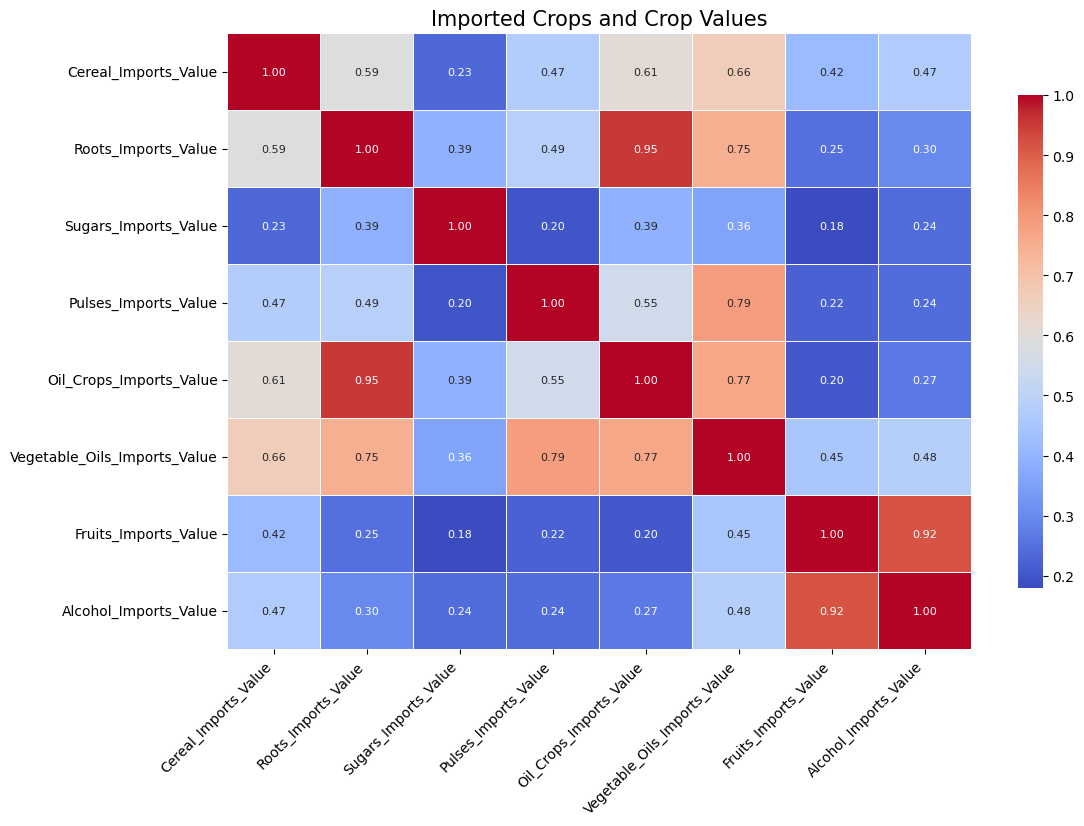

MSE: 13859803560258.578


,Feature,Importance
1,Roots_Imports_Value,0.44
6,Fruits_Imports_Value,0.30
5,Vegetable_Oils_Imports_Value,0.10
7,Alcohol_Imports_Value,0.09
4,Oil_Crops_Imports_Value,0.03
3,Pulses_Imports_Value,0.02
0,Cereal_Imports_Value,0.02
2,Sugars_Imports_Value,0.00


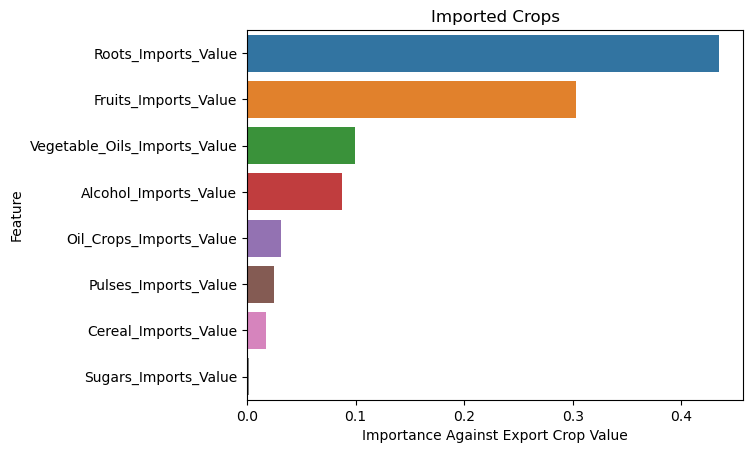

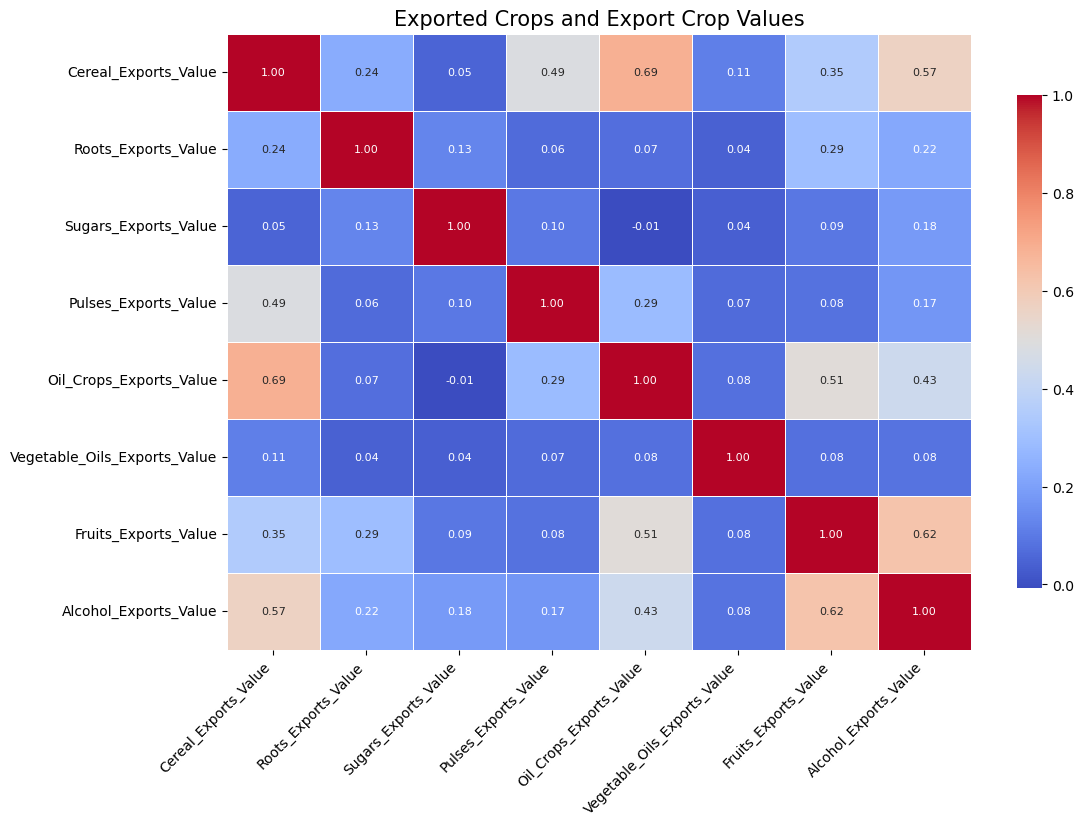

MSE: 9846976592205.086


,Feature,Importance
5,Vegetable_Oils_Exports_Value,0.51
7,Alcohol_Exports_Value,0.20
6,Fruits_Exports_Value,0.09
0,Cereal_Exports_Value,0.06
1,Roots_Exports_Value,0.06
3,Pulses_Exports_Value,0.05
4,Oil_Crops_Exports_Value,0.03
2,Sugars_Exports_Value,0.00


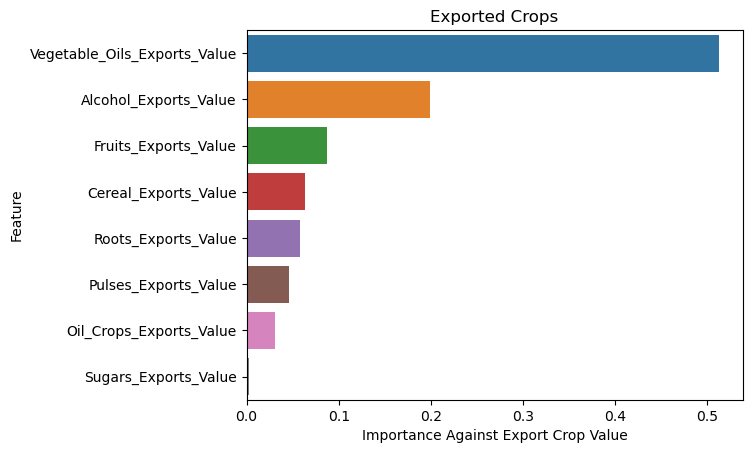

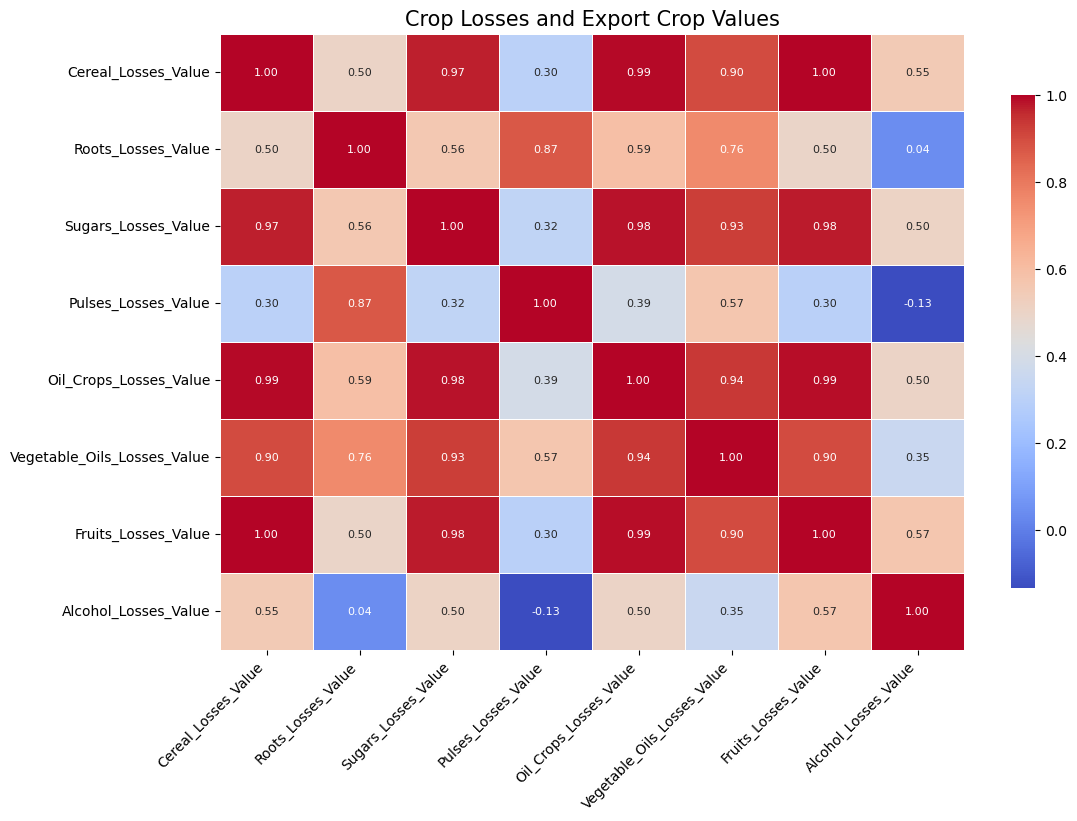

MSE: 15631711431422.566


,Feature,Importance
5,Vegetable_Oils_Losses_Value,0.26
2,Sugars_Losses_Value,0.21
6,Fruits_Losses_Value,0.18
4,Oil_Crops_Losses_Value,0.17
0,Cereal_Losses_Value,0.16
3,Pulses_Losses_Value,0.00
7,Alcohol_Losses_Value,0.00
1,Roots_Losses_Value,0.00


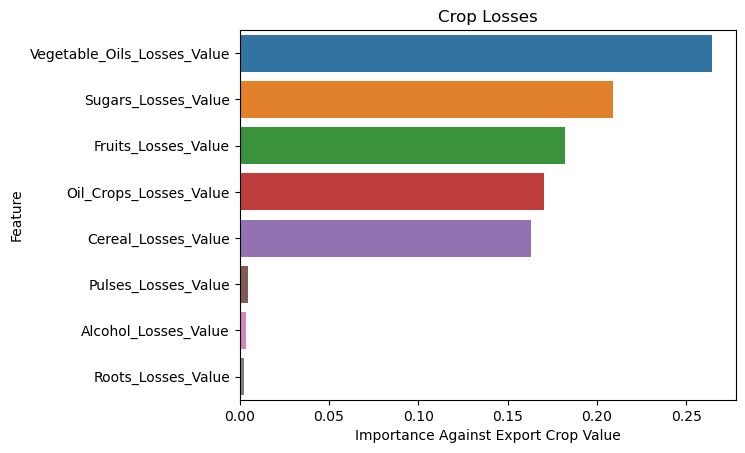

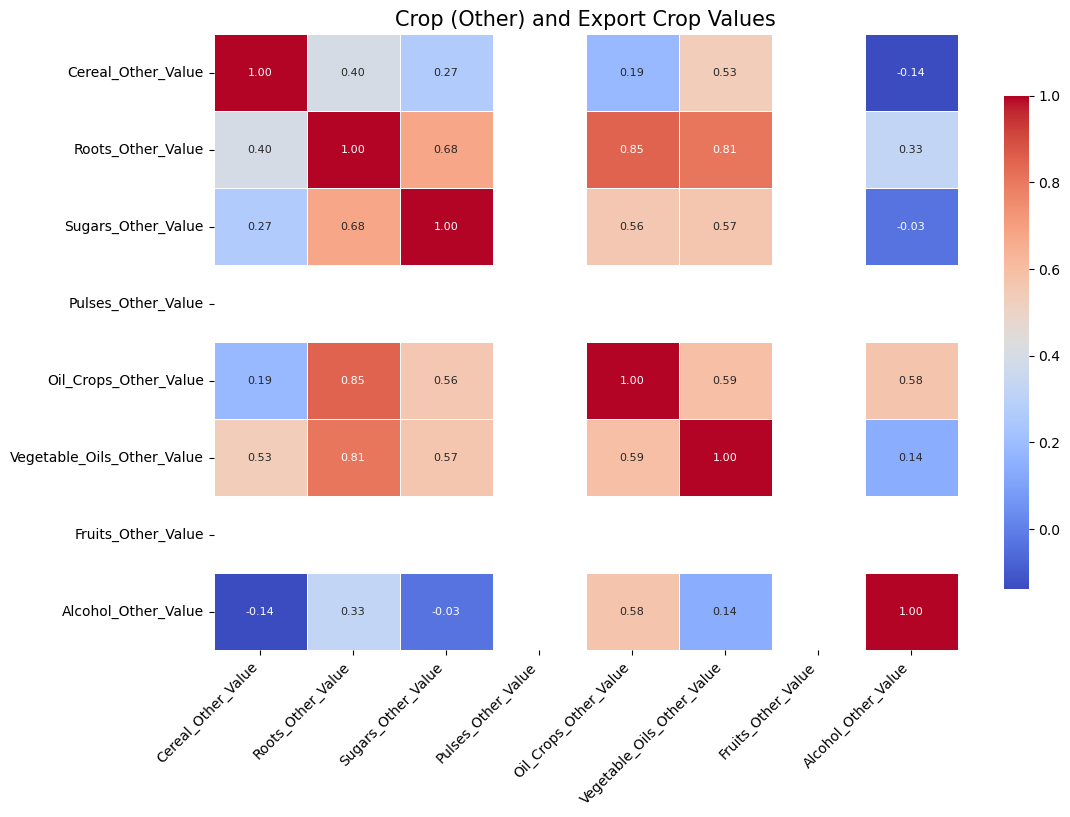

MSE: 9309790053926.186


,Feature,Importance
0,Cereal_Other_Value,0.62
1,Roots_Other_Value,0.19
2,Sugars_Other_Value,0.19
3,Pulses_Other_Value,0.00
4,Oil_Crops_Other_Value,0.00
5,Vegetable_Oils_Other_Value,0.00
6,Fruits_Other_Value,0.00
7,Alcohol_Other_Value,0.00


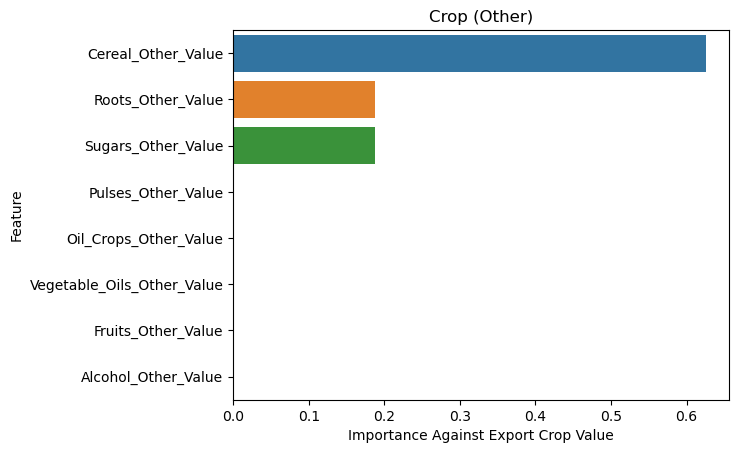

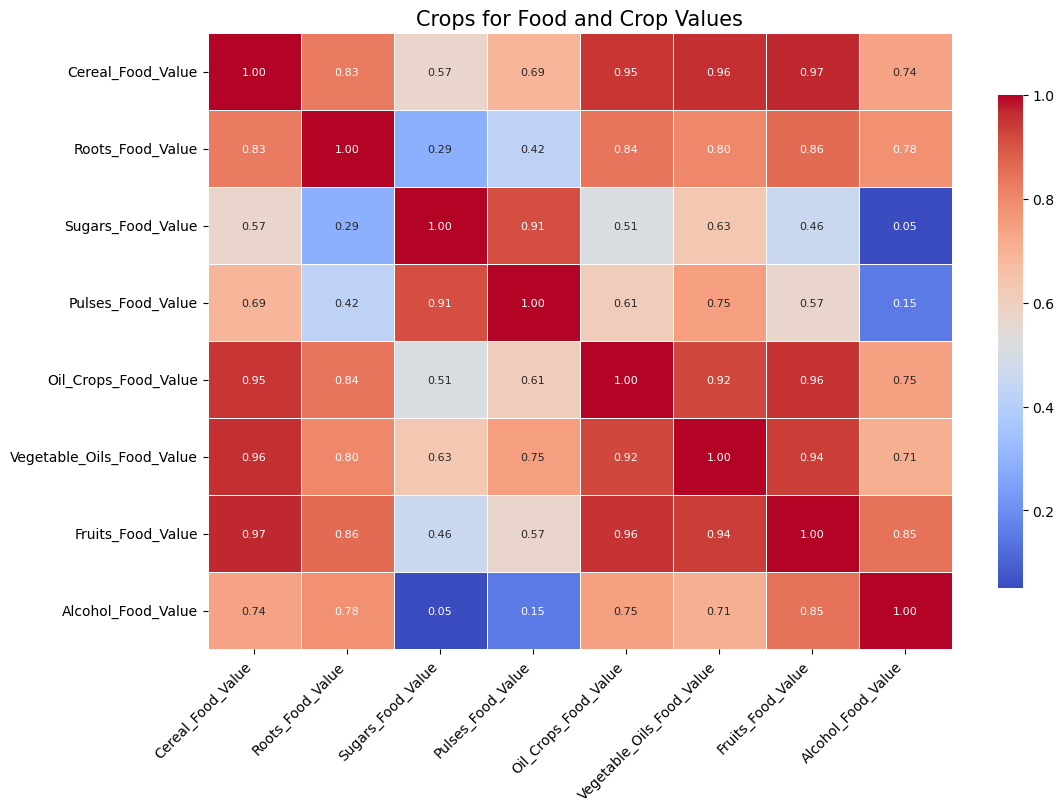

MSE: 7802566141552.482


,Feature,Importance
7,Alcohol_Food_Value,0.33
6,Fruits_Food_Value,0.24
5,Vegetable_Oils_Food_Value,0.21
0,Cereal_Food_Value,0.06
2,Sugars_Food_Value,0.05
4,Oil_Crops_Food_Value,0.05
3,Pulses_Food_Value,0.04
1,Roots_Food_Value,0.03


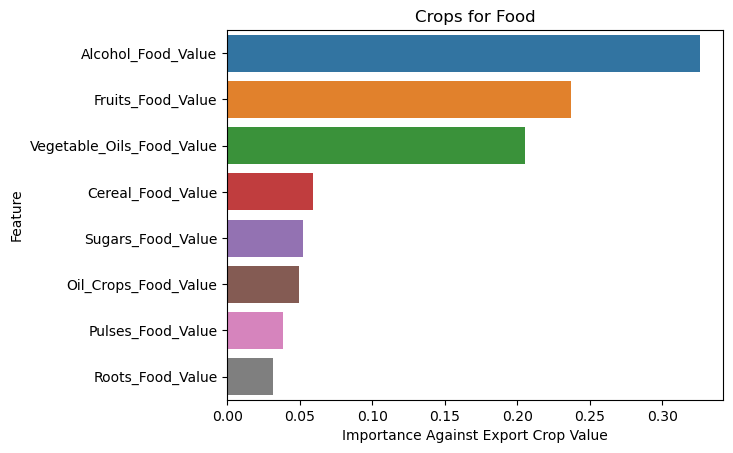

In [28]:
imports_df = pd.merge(cereal_imports, roots_imports, on=['Area', 'Year'])
imports_df = pd.merge(imports_df, sugars_imports, on=['Area', 'Year'])
imports_df = pd.merge(imports_df, pulses_imports, on=['Area', 'Year'])
imports_df = pd.merge(imports_df, oil_crops_imports, on=['Area', 'Year'])
imports_df = pd.merge(imports_df, vegetable_oils_imports, on=['Area', 'Year'])
imports_df = pd.merge(imports_df, fruits_imports, on=['Area', 'Year'])
imports_df = pd.merge(imports_df, alcohol_imports, on=['Area', 'Year'])
imports_df = pd.merge(imports_df, crop_exports_summed[['Area', 'Year', 'Annual_Crop_Export_Value']], on=['Area', 'Year'])

imports_value_cols = ['Cereal_Imports_Value', 'Roots_Imports_Value', 'Sugars_Imports_Value', 
                   'Pulses_Imports_Value', 'Oil_Crops_Imports_Value', 'Vegetable_Oils_Imports_Value', 
                   'Fruits_Imports_Value', 'Alcohol_Imports_Value']

imports_scaler = StandardScaler()
imports_df[imports_value_cols] = imports_scaler.fit_transform(imports_df[imports_value_cols])


# find linear correlation between features and crop export values
correlation = imports_df[imports_value_cols].corr()
display_heatmap(correlation, title='Imported Crops and Crop Values')
# find non-linear correlation between features and crop export values
X = imports_df[['Cereal_Imports_Value', 'Roots_Imports_Value', 'Sugars_Imports_Value', 
                   'Pulses_Imports_Value', 'Oil_Crops_Imports_Value', 'Vegetable_Oils_Imports_Value', 
                   'Fruits_Imports_Value', 'Alcohol_Imports_Value']]
y = imports_df['Annual_Crop_Export_Value']
rank_feature_importance(X, y, 'Imported Crops')

exports_df = pd.merge(cereal_exports, roots_exports, on=['Area', 'Year'])
exports_df = pd.merge(exports_df, sugars_exports, on=['Area', 'Year'])
exports_df = pd.merge(exports_df, pulses_exports, on=['Area', 'Year'])
exports_df = pd.merge(exports_df, oil_crops_exports, on=['Area', 'Year'])
exports_df = pd.merge(exports_df, vegetable_oils_exports, on=['Area', 'Year'])
exports_df = pd.merge(exports_df, fruits_exports, on=['Area', 'Year'])
exports_df = pd.merge(exports_df, alcohol_exports, on=['Area', 'Year'])
exports_df = pd.merge(exports_df, crop_exports_summed[['Area', 'Year', 'Annual_Crop_Export_Value']], on=['Area', 'Year'])

# normalise
exports_value_cols = ['Cereal_Exports_Value', 'Roots_Exports_Value', 'Sugars_Exports_Value', 
                   'Pulses_Exports_Value', 'Oil_Crops_Exports_Value', 'Vegetable_Oils_Exports_Value', 
                   'Fruits_Exports_Value', 'Alcohol_Exports_Value']
exports_scaler = StandardScaler()
exports_df[exports_value_cols] = exports_scaler.fit_transform(exports_df[exports_value_cols])
joblib.dump(exports_scaler, 'Scalers/exports_scaler.pkl')

# find linear correlation between features and crop export values
correlation = exports_df[exports_value_cols].corr()
display_heatmap(correlation, title='Exported Crops and Export Crop Values')
# find non-linear correlation between features and crop export values
X = exports_df[['Cereal_Exports_Value', 'Roots_Exports_Value', 'Sugars_Exports_Value', 
                   'Pulses_Exports_Value', 'Oil_Crops_Exports_Value', 'Vegetable_Oils_Exports_Value', 
                   'Fruits_Exports_Value', 'Alcohol_Exports_Value']]
y = exports_df['Annual_Crop_Export_Value']
rank_feature_importance(X, y, 'Exported Crops')

losses_df = pd.merge(cereal_losses, roots_losses, on=['Area', 'Year'])
losses_df = pd.merge(losses_df, sugars_losses, on=['Area', 'Year'])
losses_df = pd.merge(losses_df, pulses_losses, on=['Area', 'Year'])
losses_df = pd.merge(losses_df, oil_crops_losses, on=['Area', 'Year'])
losses_df = pd.merge(losses_df, vegetable_oils_losses, on=['Area', 'Year'])
losses_df = pd.merge(losses_df, fruits_losses, on=['Area', 'Year'])
losses_df = pd.merge(losses_df, alcohol_losses, on=['Area', 'Year'])
losses_df = pd.merge(losses_df, crop_exports_summed[['Area', 'Year', 'Annual_Crop_Export_Value']], on=['Area', 'Year'])

losses_value_cols = ['Cereal_Losses_Value', 'Roots_Losses_Value', 'Sugars_Losses_Value', 
                   'Pulses_Losses_Value', 'Oil_Crops_Losses_Value', 'Vegetable_Oils_Losses_Value', 
                   'Fruits_Losses_Value', 'Alcohol_Losses_Value']
losses_scaler = StandardScaler()
losses_df[losses_value_cols] = losses_scaler.fit_transform(losses_df[losses_value_cols])
joblib.dump(losses_scaler, 'Scalers/food_balance_losses_scaler.pkl')

# find linear correlation between features and crop export values
correlation = losses_df[losses_value_cols].corr()
display_heatmap(correlation, title='Crop Losses and Export Crop Values')
# find non-linear correlation between features and crop export values
X = losses_df[['Cereal_Losses_Value', 'Roots_Losses_Value', 'Sugars_Losses_Value', 
                   'Pulses_Losses_Value', 'Oil_Crops_Losses_Value', 'Vegetable_Oils_Losses_Value', 
                   'Fruits_Losses_Value', 'Alcohol_Losses_Value']]
y = losses_df['Annual_Crop_Export_Value']
rank_feature_importance(X, y, 'Crop Losses')

other_df = pd.merge(cereal_other, roots_other, on=['Area', 'Year'])
other_df = pd.merge(other_df, sugars_other, on=['Area', 'Year'])
other_df = pd.merge(other_df, pulses_other, on=['Area', 'Year'])
other_df = pd.merge(other_df, oil_crops_other, on=['Area', 'Year'])
other_df = pd.merge(other_df, vegetable_oils_other, on=['Area', 'Year'])
other_df = pd.merge(other_df, fruits_other, on=['Area', 'Year'])
other_df = pd.merge(other_df, alcohol_other, on=['Area', 'Year'])
other_df = pd.merge(other_df, crop_exports_summed[['Area', 'Year', 'Annual_Crop_Export_Value']], on=['Area', 'Year'])

other_value_cols = ['Cereal_Other_Value', 'Roots_Other_Value', 'Sugars_Other_Value', 
                   'Pulses_Other_Value', 'Oil_Crops_Other_Value', 'Vegetable_Oils_Other_Value', 
                   'Fruits_Other_Value', 'Alcohol_Other_Value']

other_scaler = StandardScaler()
other_df[other_value_cols] = other_scaler.fit_transform(other_df[other_value_cols])
joblib.dump(other_scaler, 'Scalers/food_balance_other_scaler.pkl')

# find linear correlation between features and crop export values
correlation = other_df[other_value_cols].corr()
display_heatmap(correlation, title='Crop (Other) and Export Crop Values')
# find non-linear correlation between features and crop export values
X = other_df[['Cereal_Other_Value', 'Roots_Other_Value', 'Sugars_Other_Value', 
                   'Pulses_Other_Value', 'Oil_Crops_Other_Value', 'Vegetable_Oils_Other_Value', 
                   'Fruits_Other_Value', 'Alcohol_Other_Value']]
y = other_df['Annual_Crop_Export_Value']
rank_feature_importance(X, y, 'Crop (Other)')

food_df = pd.merge(cereal_food, roots_food, on=['Area', 'Year'])
food_df = pd.merge(food_df, sugars_food, on=['Area', 'Year'])
food_df = pd.merge(food_df, pulses_food, on=['Area', 'Year'])
food_df = pd.merge(food_df, oil_crops_food, on=['Area', 'Year'])
food_df = pd.merge(food_df, vegetable_oils_food, on=['Area', 'Year'])
food_df = pd.merge(food_df, fruits_food, on=['Area', 'Year'])
food_df = pd.merge(food_df, alcohol_food, on=['Area', 'Year'])
food_df = pd.merge(food_df, crop_exports_summed[['Area', 'Year', 'Annual_Crop_Export_Value']], on=['Area', 'Year'])

food_value_cols = ['Cereal_Food_Value', 'Roots_Food_Value', 'Sugars_Food_Value', 
                   'Pulses_Food_Value', 'Oil_Crops_Food_Value', 'Vegetable_Oils_Food_Value', 
                   'Fruits_Food_Value', 'Alcohol_Food_Value']
food_scaler = StandardScaler()
food_df[food_value_cols] = food_scaler.fit_transform(food_df[food_value_cols])
joblib.dump(food_scaler, 'Scalers/food_scaler.pkl')

# find linear correlation between features and crop export values
correlation = food_df[food_value_cols].corr()
display_heatmap(correlation, title='Crops for Food and Crop Values')
# find non-linear correlation between features and crop export values
X = food_df[['Cereal_Food_Value', 'Roots_Food_Value', 'Sugars_Food_Value', 
                   'Pulses_Food_Value', 'Oil_Crops_Food_Value', 'Vegetable_Oils_Food_Value', 
                   'Fruits_Food_Value', 'Alcohol_Food_Value']]
y = food_df['Annual_Crop_Export_Value']
rank_feature_importance(X, y, 'Crops for Food')

### food_security_indicator.csv

In [29]:
security_indicators = pd.read_csv('Data/raw_data/food_security_indicators.csv')
security_indicators = security_indicators.drop(columns=['Domain Code', 'Domain', 
                                                        'Area Code (M49)', 'Element', 'Element Code', 
                                                        'Item Code', 'Year Code', 
                                                        'Unit', 'Flag', 'Flag Description', 'Note'])

# data has years in format str(x-y)
# take the y value so more rows fit with the years bounded 2002-2022
security_indicators['Year'] = security_indicators['Year'].apply(lambda x: int(x.split('-')[1] if '-' in x else int(x)))
# convert from string to integer
security_indicators['Year'] = security_indicators['Year'].astype(int)

security_indicators = security_indicators[(security_indicators['Year'] >= 2002) & (security_indicators['Year'] <= 2022)]

unique_items = security_indicators['Item'].unique()
print(f'Unique Items: {unique_items}\n')

Unique Items: ['Average dietary energy supply adequacy (percent) (3-year average)'
 'Average protein supply (g/cap/day) (3-year average)'
 'Cereal import dependency ratio (percent) (3-year average)'
 'Percent of arable land equipped for irrigation (percent) (3-year average)'
 'Value of food imports in total merchandise exports (percent) (3-year average)'
 'Political stability and absence of violence/terrorism (index)'
 'Per capita food production variability (constant 2014-2016 thousand int$ per capita)'
 'Per capita food supply variability (kcal/cap/day)'
 'Prevalence of anemia among women of reproductive age (15-49 years)'
 'Prevalence of low birthweight (percent)']



In [30]:
dietary_energy = security_indicators[security_indicators['Item'] == unique_items[0]].copy()
dietary_energy = dietary_energy.rename(columns={'Value': 'Dietary_Value', 'Item': 'Dietary_Item'})

cereal_dependency = security_indicators[security_indicators['Item'] == unique_items[1]].copy()
cereal_dependency = cereal_dependency.rename(columns={'Value': 'Cereal_Value', 'Item': 'Cereal_Item'})

irrigation_land = security_indicators[security_indicators['Item'] == unique_items[2]].copy()
irrigation_land = irrigation_land.rename(columns={'Value': 'Irrigation_Value', 'Item': 'Irrigation_Item'})

food_imports_in_merch = security_indicators[security_indicators['Item'] == unique_items[3]].copy()
food_imports_in_merch = food_imports_in_merch.rename(columns={'Value': 'Imports_Value', 'Item': 'Imports_Item'})

stability = security_indicators[security_indicators['Item'] == unique_items[4]].copy()
stability = stability.rename(columns={'Value': 'Stability_Value', 'Item': 'Stability_Item'})

food_prod_variability = security_indicators[security_indicators['Item'] == unique_items[5]].copy()
food_prod_variability = food_prod_variability.rename(columns={'Value': 'Prod_Value', 'Item': 'Prod_Item'})

food_supply_variability = security_indicators[security_indicators['Item'] == unique_items[6]].copy()
food_supply_variability = food_supply_variability.rename(columns={'Value': 'Supply_Value', 'Item': 'Supply_Item'})

anemia_among_women = security_indicators[security_indicators['Item'] == unique_items[7]].copy()
anemia_among_women = anemia_among_women.rename(columns={'Value': 'Anemia_Value', 'Item': 'Anemia_Item'})

low_birthweight = security_indicators[security_indicators['Item'] == unique_items[8]].copy()
low_birthweight = low_birthweight.rename(columns={'Value': 'Birthweight_Value', 'Item': 'Birthweight_Item'})

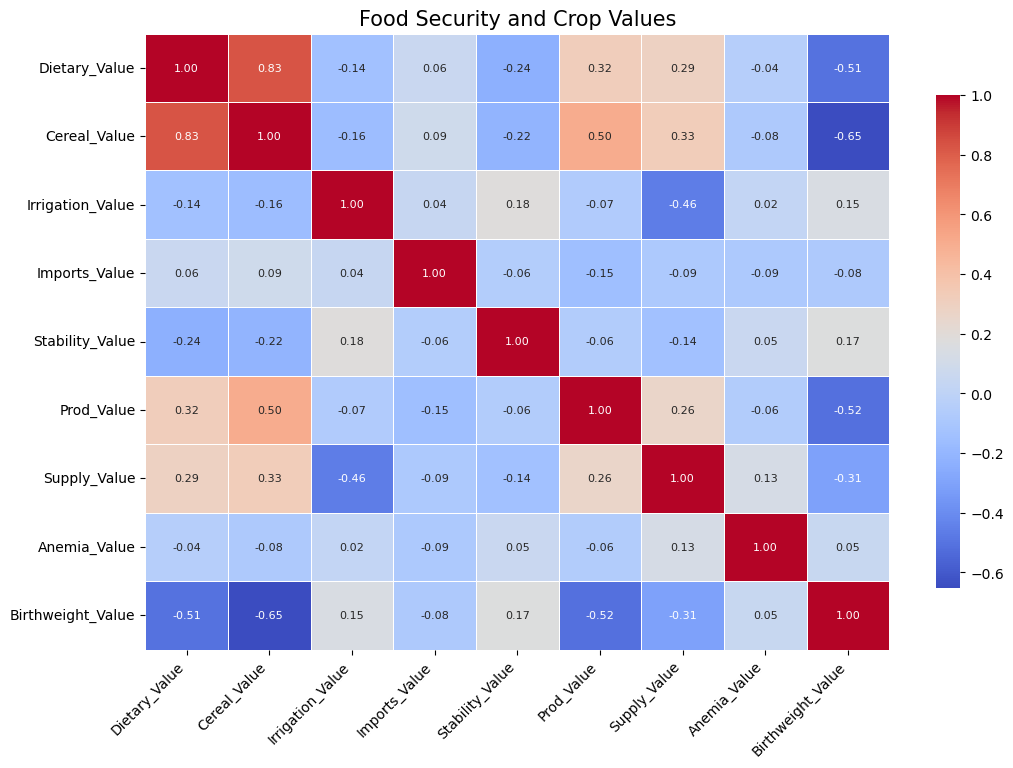

MSE: 11859335197261.467


,Feature,Importance
8,Birthweight_Value,0.29
0,Dietary_Value,0.17
3,Imports_Value,0.14
2,Irrigation_Value,0.13
4,Stability_Value,0.07
6,Supply_Value,0.07
5,Prod_Value,0.06
1,Cereal_Value,0.06
7,Anemia_Value,0.01


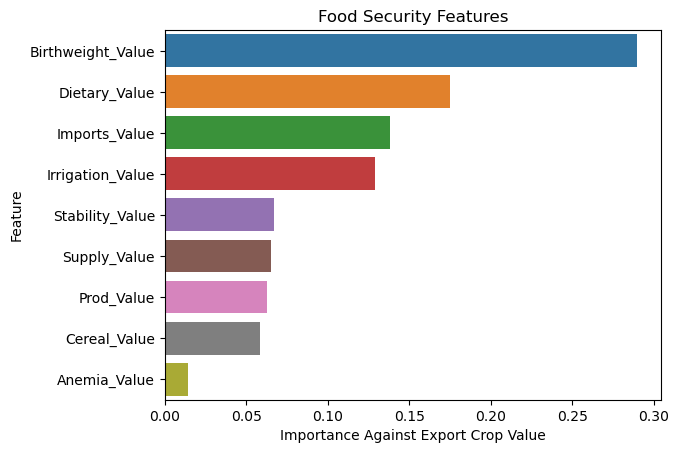

In [31]:
food_security_df = pd.merge(dietary_energy, cereal_dependency, on=['Area', 'Year'])
food_security_df = pd.merge(food_security_df, irrigation_land, on=['Area', 'Year'])
food_security_df = pd.merge(food_security_df, food_imports_in_merch, on=['Area', 'Year'])
food_security_df = pd.merge(food_security_df, stability, on=['Area', 'Year'])
food_security_df = pd.merge(food_security_df, food_prod_variability, on=['Area', 'Year'])
food_security_df = pd.merge(food_security_df, food_supply_variability, on=['Area', 'Year'])
food_security_df = pd.merge(food_security_df, anemia_among_women, on=['Area', 'Year'])
food_security_df = pd.merge(food_security_df, low_birthweight, on=['Area', 'Year'])
food_security_df = pd.merge(food_security_df, crop_exports_summed[['Area', 'Year', 'Annual_Crop_Export_Value']], on=['Area', 'Year'])

food_security_cols = ['Dietary_Value', 'Cereal_Value', 'Irrigation_Value', 
                   'Imports_Value', 'Stability_Value', 'Prod_Value', 
                   'Supply_Value', 'Anemia_Value', 'Birthweight_Value']
food_sec_scaler = StandardScaler()
food_security_df[food_security_cols] = food_sec_scaler.fit_transform(food_security_df[food_security_cols])
joblib.dump(food_sec_scaler, 'Scalers/food_sec_scaler.pkl')

# find linear correlation between features and crop export values
correlation = food_security_df[food_security_cols].corr()
display_heatmap(correlation, title='Food Security and Crop Values')
# find non-linear correlation between features and crop export values
X = food_security_df[['Dietary_Value', 'Cereal_Value', 'Irrigation_Value', 
                   'Imports_Value', 'Stability_Value', 'Prod_Value', 
                   'Supply_Value', 'Anemia_Value', 'Birthweight_Value']]
y = food_security_df['Annual_Crop_Export_Value']
rank_feature_importance(X, y, 'Food Security Features')

### foreign_direct_investment.csv

In [32]:
foreign_direct_investment = pd.read_csv('Data/raw_data/foreign_direct_investment.csv')
foreign_direct_investment = foreign_direct_investment.drop(columns=['Domain Code', 
                                                                    'Domain', 
                                                                    'Area Code (M49)', 
                                                                    'Element Code', 
                                                                    'Element', 
                                                                    'Item Code', 
                                                                    'Year Code', 
                                                                    'Unit', 
                                                                    'Flag', 
                                                                    'Flag Description', 
                                                                    'Note'])
foreign_direct_investment = foreign_direct_investment[(foreign_direct_investment['Year'] >= 2002) & (foreign_direct_investment['Year'] <= 2022)]

unique_items = foreign_direct_investment['Item'].unique()
print(f'Unique Items: {unique_items}\n')

Unique Items: ['Total FDI inflows' 'Total FDI outflows'
 'FDI inflows to Agriculture, Forestry and Fishing'
 'FDI inflows to Food, Beverages and Tobacco'
 'FDI outflows to Agriculture, Forestry and Fishing'
 'FDI outflows to Food, Beverages and Tobacco']



In [33]:
total_inflow = foreign_direct_investment[foreign_direct_investment['Item'] == unique_items[0]].copy()
total_inflow = total_inflow.rename(columns={'Value': 'Total_Inflow_Value', 'Item': 'Total_Inflow_Item'})

total_outflow = foreign_direct_investment[foreign_direct_investment['Item'] == unique_items[1]].copy()
total_outflow = total_outflow.rename(columns={'Value': 'Total_Outflow_Value', 'Item': 'Total_OutflowItem'})

aff_inflow = foreign_direct_investment[foreign_direct_investment['Item'] == unique_items[2]].copy()
aff_inflow = aff_inflow.rename(columns={'Value': 'Total_AFF_Inflow_Value', 'Item': 'Total_AFF_Inflow_Item'})

fbt_inflow = foreign_direct_investment[foreign_direct_investment['Item'] == unique_items[3]].copy()
fbt_inflow = fbt_inflow.rename(columns={'Value': 'Total_FBT_Inflow_Value', 'Item': 'Total_FBT_Inflow_Item'})

aff_outflow = foreign_direct_investment[foreign_direct_investment['Item'] == unique_items[4]].copy()
aff_outflow = aff_outflow.rename(columns={'Value': 'Total_AFF_Outflow_Value', 'Item': 'Total_AFF_Outflow_Item'})

fbt_outflow = foreign_direct_investment[foreign_direct_investment['Item'] == unique_items[5]].copy()
fbt_outflow = fbt_outflow.rename(columns={'Value': 'Total_FBT_Outflow_Value', 'Item': 'Total_FBT_Outflow_Item'})

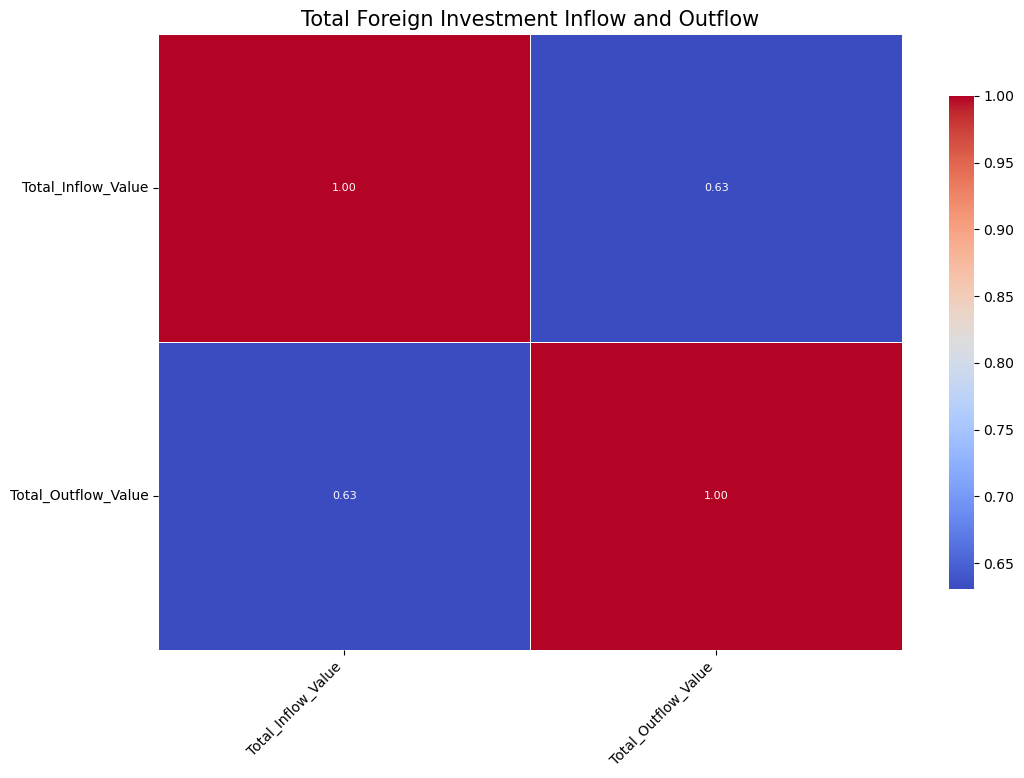

MSE: 56428495320997.99


,Feature,Importance
0,Total_Inflow_Value,0.58
1,Total_Outflow_Value,0.42


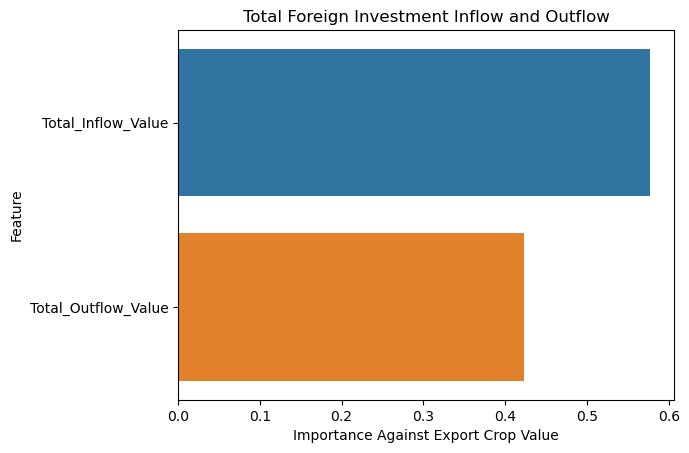

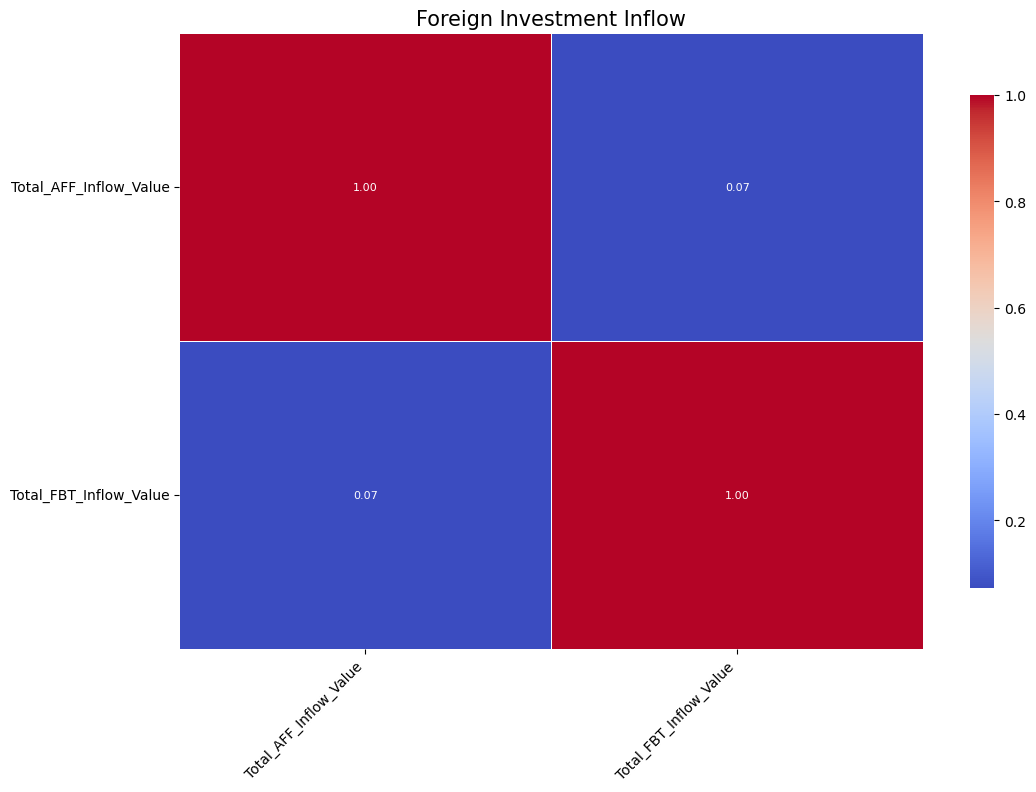

MSE: 118923290077689.16


,Feature,Importance
1,Total_FBT_Inflow_Value,0.89
0,Total_AFF_Inflow_Value,0.11


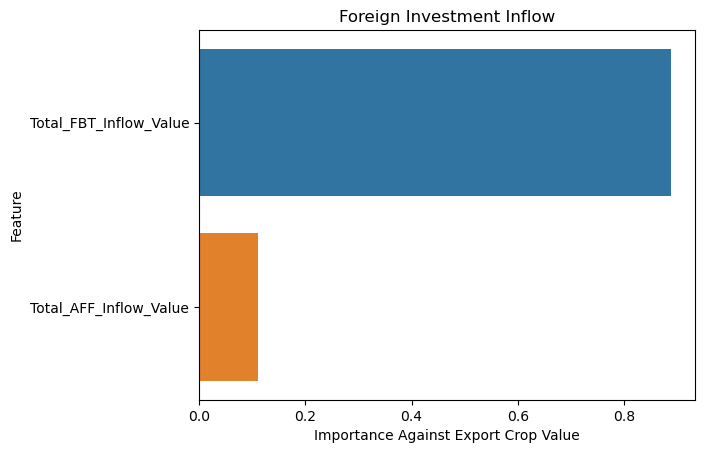

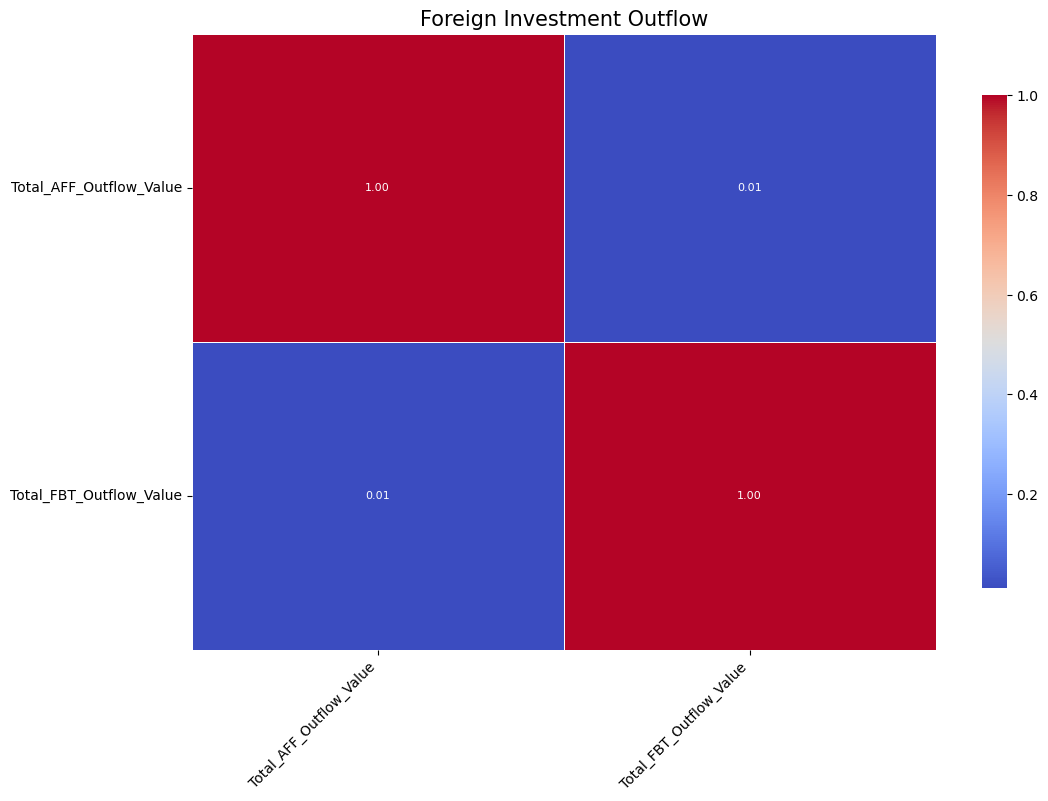

MSE: 134715113249483.52


,Feature,Importance
1,Total_FBT_Outflow_Value,0.51
0,Total_AFF_Outflow_Value,0.49


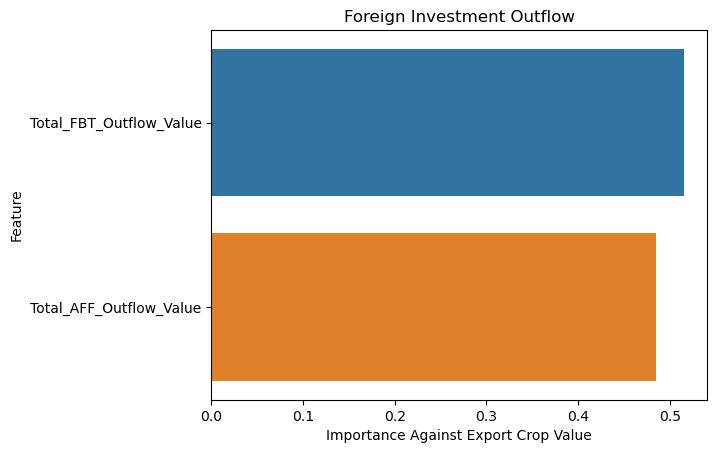

In [34]:
totals_df = pd.merge(total_inflow, total_outflow, on=['Area', 'Year'])
totals_df = pd.merge(totals_df, crop_exports_summed[['Area', 'Year', 'Annual_Crop_Export_Value']], on=['Area', 'Year'])

totals_value_cols = ['Total_Inflow_Value', 'Total_Outflow_Value']
totals_scaler = StandardScaler()
totals_df[totals_value_cols] = totals_scaler.fit_transform(totals_df[totals_value_cols])
joblib.dump(totals_scaler, 'Scalers/fdi_totals_scaler.pkl')

# find linear correlation between features and crop export values
correlation = totals_df[totals_value_cols].corr()
display_heatmap(correlation, title='Total Foreign Investment Inflow and Outflow')
# find non-linear correlation between features and crop export values
X = totals_df[['Total_Inflow_Value', 'Total_Outflow_Value']]
y = totals_df['Annual_Crop_Export_Value']
rank_feature_importance(X, y, 'Total Foreign Investment Inflow and Outflow')

foreign_investment_inflow = pd.merge(aff_inflow, fbt_inflow, on=['Area', 'Year'])
foreign_investment_inflow = pd.merge(foreign_investment_inflow, crop_exports_summed[['Area', 'Year', 'Annual_Crop_Export_Value']], on=['Area', 'Year'])

totals_value_cols = ['Total_AFF_Inflow_Value', 'Total_FBT_Inflow_Value']
fdi_inflow_scaler = StandardScaler()
foreign_investment_inflow[totals_value_cols] = fdi_inflow_scaler.fit_transform(foreign_investment_inflow[totals_value_cols])
joblib.dump(fdi_inflow_scaler, 'Scalers/fdi_inflow_scaler.pkl')

# find linear correlation between features and crop export values
correlation = foreign_investment_inflow[totals_value_cols].corr()
display_heatmap(correlation, title='Foreign Investment Inflow')
# find non-linear correlation between features and crop export values
X = foreign_investment_inflow[['Total_AFF_Inflow_Value', 'Total_FBT_Inflow_Value']]
y = foreign_investment_inflow['Annual_Crop_Export_Value']
rank_feature_importance(X, y, 'Foreign Investment Inflow')

foreign_investment_outflow = pd.merge(aff_outflow, fbt_outflow, on=['Area', 'Year'])
foreign_investment_outflow = pd.merge(foreign_investment_outflow, crop_exports_summed[['Area', 'Year', 'Annual_Crop_Export_Value']], on=['Area', 'Year'])

totals_value_cols = ['Total_AFF_Outflow_Value', 'Total_FBT_Outflow_Value']
fdi_outflow_scaler = StandardScaler()
foreign_investment_outflow[totals_value_cols] = fdi_outflow_scaler.fit_transform(foreign_investment_outflow[totals_value_cols])
joblib.dump(fdi_outflow_scaler, 'Scalers/fdi_outflow_scaler.pkl')

# find linear correlation between features and crop export values
correlation = foreign_investment_outflow[totals_value_cols].corr()
display_heatmap(correlation, title='Foreign Investment Outflow')
# find non-linear correlation between features and crop export values
X = foreign_investment_outflow[['Total_AFF_Outflow_Value', 'Total_FBT_Outflow_Value']]
y = foreign_investment_outflow['Annual_Crop_Export_Value']
rank_feature_importance(X, y, 'Foreign Investment Outflow')


### land_temperature_change.csv

In [35]:
land_temp_change = pd.read_csv('Data/raw_data/land_temperature_change.csv')

# use the Flag Description column to find NaN values and fix them
for i in range(len(land_temp_change)):
    if 'Missing' in land_temp_change.loc[i, 'Flag Description']:
        if i > 0 and i < len(land_temp_change) - 1:
            year_before = land_temp_change.loc[i - 1, 'Value']
            year_after = land_temp_change.loc[i + 1, 'Value']
            # if values on both sides are available use an average
            if pd.notna(year_before) and pd.notna(year_after):
                land_temp_change.loc[i, 'Value'] = (year_before + year_after) / 2
            # otherwise use the year before
            elif pd.notna(year_before):
                land_temp_change.loc[i, 'Value'] = year_before
            # otherwise use the year after
            elif pd.notna(year_after):
                land_temp_change.loc[i, 'Value'] = year_after
                
land_temp_change = land_temp_change.drop(columns=['Domain Code', 'Domain', 'Area Code (M49)', 
                                                  'Element Code', 'Months Code', 'Months', 
                                                  'Year Code', 'Unit', 'Flag', 'Flag Description'])
                
land_temp_change = land_temp_change[(land_temp_change['Year'] >= 2002) & (land_temp_change['Year'] <= 2022)]

unique_items = land_temp_change['Element'].unique()
print(f'Unique elements: {unique_items}')

Unique elements: ['Temperature change' 'Standard Deviation']


In [36]:
temp_change = land_temp_change[land_temp_change['Element'] == unique_items[0]].copy()
temp_change = temp_change.rename(columns={'Value': 'Temp_Value', 'Element': 'Temp_Element'})

std_dev = land_temp_change[land_temp_change['Element'] == unique_items[1]].copy()
std_dev = std_dev.rename(columns={'Value': 'Std_Dev_Value', 'Element': 'Std_Dev_Element'})

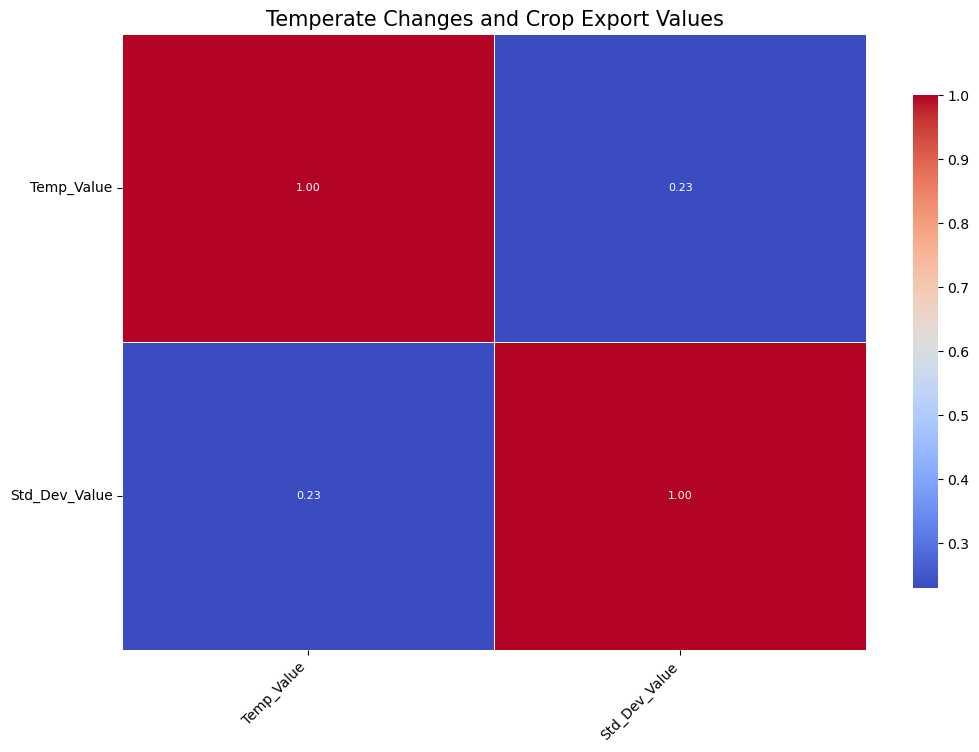

MSE: 69819088124521.5


,Feature,Importance
1,Std_Dev_Value,0.88
0,Temp_Value,0.12


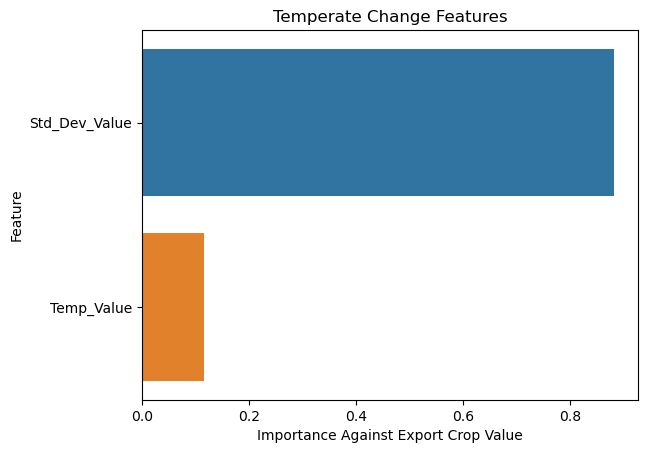

In [37]:
temp_df = pd.merge(temp_change, std_dev, on=['Area', 'Year'])
temp_df = pd.merge(temp_df, crop_exports_summed[['Area', 'Year', 'Annual_Crop_Export_Value']], on=['Area', 'Year'])

# normalise
value_cols = ['Temp_Value', 'Std_Dev_Value']
temp_df_scaler = StandardScaler()
temp_df[value_cols] = temp_df_scaler.fit_transform(temp_df[value_cols])
joblib.dump(temp_df_scaler, 'Scalers/temp_df_scaler.pkl')

# find linear correlation between features and crop export values
correlation = temp_df[value_cols].corr()
display_heatmap(correlation, title='Temperate Changes and Crop Export Values')

# find non-linear correlation between features and crop export values
X = temp_df[['Temp_Value', 'Std_Dev_Value']]
y = temp_df['Annual_Crop_Export_Value']
rank_feature_importance(X, y, 'Temperate Change Features')

### land_use.csv

In [38]:
land_use = pd.read_csv('Data/raw_data/land_use.csv')
                
land_use = land_use.drop(columns=['Domain Code', 'Domain', 'Area Code (M49)', 
                                                  'Element Code', 'Element', 'Item Code', 
                                                  'Year Code', 'Unit', 'Flag', 'Flag Description', 'Note'])
                
land_use = land_use[(land_use['Year'] >= 2002) & (land_use['Year'] <= 2022)]

unique_items = land_use['Item'].unique()
print(f'Unique items: {unique_items}\n')

Unique items: ['Country area' 'Land area' 'Agriculture' 'Agricultural land' 'Cropland'
 'Arable land' 'Temporary crops' 'Temporary meadows and pastures'
 'Temporary fallow' 'Permanent crops' 'Permanent meadows and pastures'
 'Perm. meadows & pastures - Nat. growing'
 'Land area equipped for irrigation' 'Land area actually irrigated'
 'Agriculture area actually irrigated' 'Farm buildings and Farmyards'
 'Cropland area actually irrigated'
 'Perm. meadows & pastures - Cultivated'
 'Perm. meadows & pastures area actually irrig.'
 'Forestry area actually irrigated']



/var/folders/r7/pmx4mq9n359ff5rbmwjtfsqh0000gn/T/ipykernel_7568/2003263151.py:1: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  land_use = pd.read_csv('Data/raw_data/land_use.csv')


In [39]:
country_area = land_use[land_use['Item'] == unique_items[0]].copy()
country_area = country_area.rename(columns={'Value': 'Country_Area_Value', 
                                            'Item': 'Country_Area_Item'})

land_area = land_use[land_use['Item'] == unique_items[1]].copy()
land_area = land_area.rename(columns={'Value': 'Land_Use_Value', 
                                      'Item': 'Land_Use_Item'})

agriculture = land_use[land_use['Item'] == unique_items[2]].copy()
agriculture = agriculture.rename(columns={'Value': 'Agriculture_Value', 
                                          'Item': 'Agriculture_Item'})

agricultural_land = land_use[land_use['Item'] == unique_items[3]].copy()
agricultural_land = agricultural_land.rename(columns={'Value': 'Agricultural_Land_Value', 
                                                      'Item': 'Agricultural_Land_Item'})

cropland = land_use[land_use['Item'] == unique_items[4]].copy()
cropland = cropland.rename(columns={'Value': 'Cropland_Value', 
                                    'Item': 'Cropland_Item'})

arable_land = land_use[land_use['Item'] == unique_items[5]].copy()
arable_land = arable_land.rename(columns={'Value': 'Arable_Land_Value', 
                                          'Item': 'Arable_Land_Item'})

temporary_crops = land_use[land_use['Item'] == unique_items[6]].copy()
temporary_crops = temporary_crops.rename(columns={'Value': 'Temporary_Crops_Value', 
                                                  'Item': 'Temporary_Crops_Item'})

temp_meadows = land_use[land_use['Item'] == unique_items[7]].copy()
temp_meadows = temp_meadows.rename(columns={'Value': 'Temp_Meadows_And_Pastures_Value', 
                                            'Item': 'Temp_Meadows_And_Pastures_Item'})

temp_fallow = land_use[land_use['Item'] == unique_items[8]].copy()
temp_fallow = temp_fallow.rename(columns={'Value': 'Temporary_Fallow_Value', 
                                          'Item': 'Temporary_Fallow_Item'})

permanent_crops = land_use[land_use['Item'] == unique_items[9]].copy()
permanent_crops = permanent_crops.rename(columns={'Value': 'Permanent_Crops_Value', 
                                                  'Item': 'Permanent_Crops_Item'})

permanent_meadows = land_use[land_use['Item'] == unique_items[10]].copy()
permanent_meadows = permanent_meadows.rename(columns={'Value': 'Permanent_Meadows_And_Pastures_Value', 
                                                      'Item': 'Permanent_Meadows_And_Pastures_Item'})

nat_perm_meadows = land_use[land_use['Item'] == unique_items[11]].copy()
nat_perm_meadows = nat_perm_meadows.rename(columns={'Value': 'Nat_Perm_Meadows_And_Pastures_Value', 
                                                    'Item': 'Nat_Perm_Meadows_And_Pastures_Item'})

land_equipped_irr = land_use[land_use['Item'] == unique_items[12]].copy()
land_equipped_irr = land_equipped_irr.rename(columns={'Value': 'Land_Equipped_For_Irrigation_Value', 
                                                      'Item': 'Land_Equipped_For_Irrigation_Item'})

irrigated_land = land_use[land_use['Item'] == unique_items[13]].copy()
irrigated_land = irrigated_land.rename(columns={'Value': 'Irrigated_Land_Value', 
                                                'Item': 'Irrigated_Land_Item'})

agricultural_land_irr = land_use[land_use['Item'] == unique_items[14]].copy()
agricultural_land_irr = agricultural_land_irr.rename(columns={'Value': 'Irrigated_Agricultural_Land_Value', 
                                                              'Item': 'Irrigated_Agricultural_Land_Item'})

farm_buildings = land_use[land_use['Item'] == unique_items[15]].copy()
farm_buildings = farm_buildings.rename(columns={'Value': 'Farm_Buildings_Value', 
                                                'Item': 'Farm_Buildings_Item'})

irrigated_crop_land = land_use[land_use['Item'] == unique_items[16]].copy()
irrigated_crop_land = irrigated_crop_land.rename(columns={'Value': 'Irrigated_Crop_Land_Value', 
                                                          'Item': 'Irrigated_Crop_Land_Item'})

permanent_meadows_irr = land_use[land_use['Item'] == unique_items[17]].copy()
permanent_meadows_irr = permanent_meadows_irr.rename(columns={'Value': 'Permanent_Meadows_And_Pastures_Irrigated_Value', 
                                                              'Item': 'Permanent_Meadows_And_Pastures_Irrigated_Item'})

irrigated_foresty = land_use[land_use['Item'] == unique_items[18]].copy()
irrigated_foresty = irrigated_foresty.rename(columns={'Value': 'Irrigated_Forestry_Value', 
                                                          'Item': 'Irrigated_Forestry_Item'})

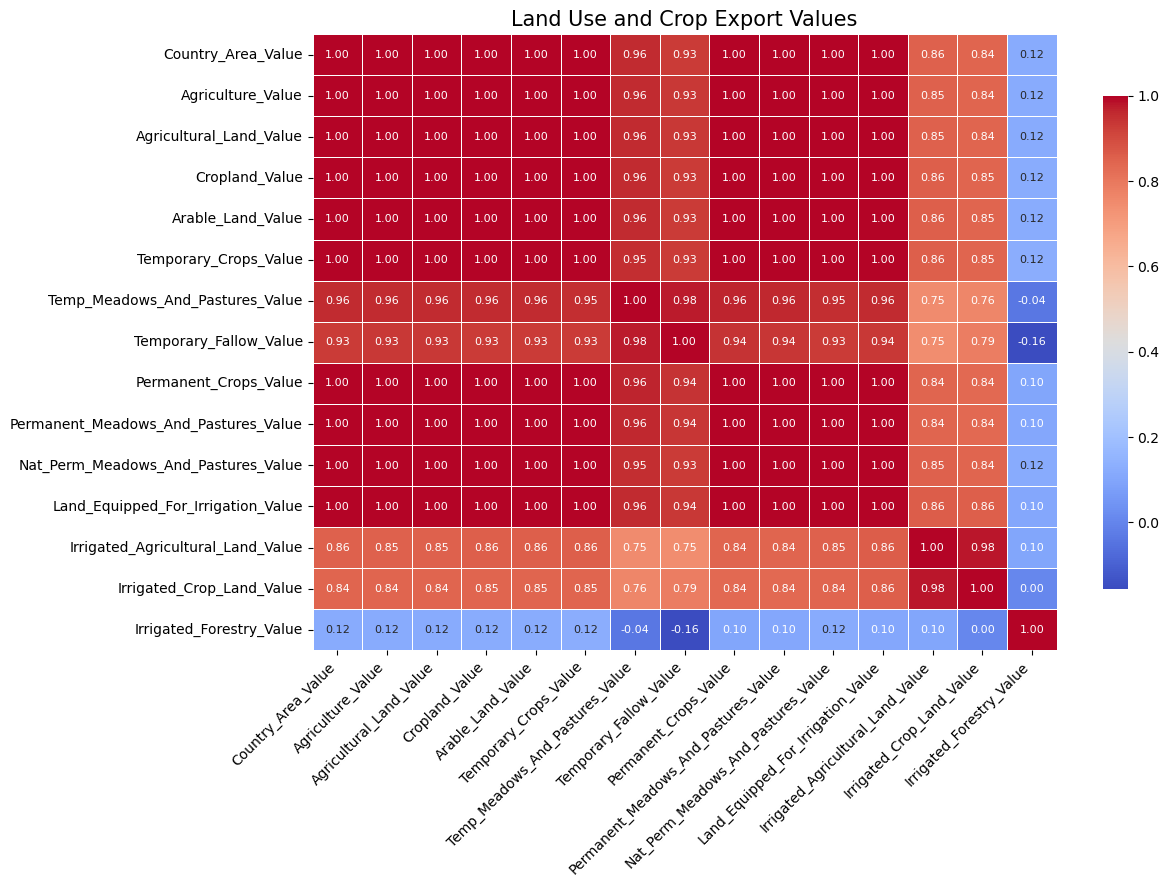

MSE: 20702053518671.2


,Feature,Importance
12,Irrigated_Agricultural_Land_Value,0.19
13,Irrigated_Crop_Land_Value,0.19
3,Cropland_Value,0.12
5,Temporary_Crops_Value,0.12
8,Permanent_Crops_Value,0.12
11,Land_Equipped_For_Irrigation_Value,0.12
4,Arable_Land_Value,0.06
10,Nat_Perm_Meadows_And_Pastures_Value,0.06
0,Country_Area_Value,0.00
1,Agriculture_Value,0.00


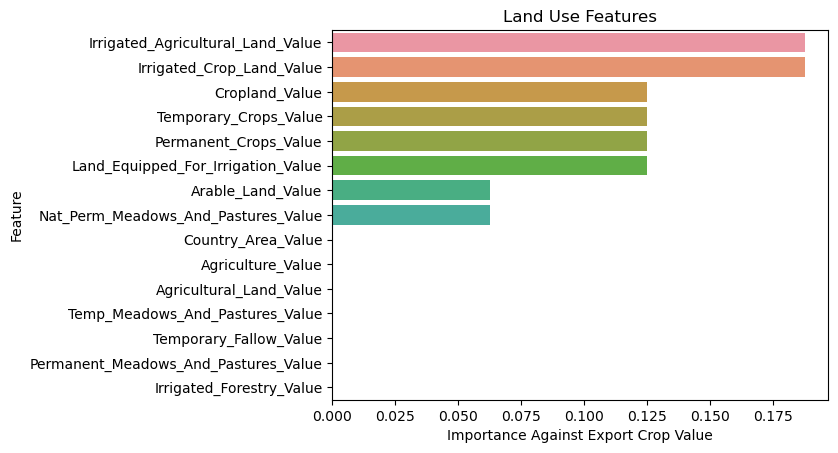

In [40]:
land_use_df = pd.merge(country_area, land_area, on=['Year', 'Area'])
land_use_df = pd.merge(land_use_df, agriculture, on=['Year', 'Area'])
land_use_df = pd.merge(land_use_df, agricultural_land, on=['Year', 'Area'])
land_use_df = pd.merge(land_use_df, cropland, on=['Year', 'Area'])
land_use_df = pd.merge(land_use_df, arable_land, on=['Year', 'Area'])
land_use_df = pd.merge(land_use_df, temporary_crops, on=['Year', 'Area'])
land_use_df = pd.merge(land_use_df, temp_meadows, on=['Year', 'Area'])
land_use_df = pd.merge(land_use_df, temp_fallow, on=['Year', 'Area'])
land_use_df = pd.merge(land_use_df, permanent_crops, on=['Year', 'Area'])
land_use_df = pd.merge(land_use_df, permanent_meadows, on=['Year', 'Area'])
land_use_df = pd.merge(land_use_df, nat_perm_meadows, on=['Year', 'Area'])
land_use_df = pd.merge(land_use_df, land_equipped_irr, on=['Year', 'Area'])
land_use_df = pd.merge(land_use_df, irrigated_land, on=['Year', 'Area'])
land_use_df = pd.merge(land_use_df, agricultural_land_irr, on=['Year', 'Area'])
land_use_df = pd.merge(land_use_df, farm_buildings, on=['Year', 'Area'])
land_use_df = pd.merge(land_use_df, irrigated_crop_land, on=['Year', 'Area'])
land_use_df = pd.merge(land_use_df, permanent_meadows_irr, on=['Year', 'Area'])
land_use_df = pd.merge(land_use_df, irrigated_foresty, on=['Year', 'Area'])
land_use_df = pd.merge(land_use_df, crop_exports_summed[['Area', 'Year', 'Annual_Crop_Export_Value']], on=['Area', 'Year'])

# normalise
value_cols = ['Country_Area_Value', 'Agriculture_Value', 'Agricultural_Land_Value', 
              'Cropland_Value', 'Arable_Land_Value', 'Temporary_Crops_Value',
              'Temp_Meadows_And_Pastures_Value', 'Temporary_Fallow_Value', 'Permanent_Crops_Value',
              'Permanent_Meadows_And_Pastures_Value', 'Nat_Perm_Meadows_And_Pastures_Value', 
              'Land_Equipped_For_Irrigation_Value', 'Irrigated_Agricultural_Land_Value', 
              'Irrigated_Crop_Land_Value', 'Irrigated_Forestry_Value']
land_use_scaler = StandardScaler()
land_use_df[value_cols] = land_use_scaler.fit_transform(land_use_df[value_cols])
joblib.dump(land_use_scaler, 'Scalers/land_use_scaler.pkl')

# find linear correlation between features and crop export values
correlation = land_use_df[value_cols].corr()
display_heatmap(correlation, title='Land Use and Crop Export Values')

# find non-linear correlation between features and crop export values
X = land_use_df[['Country_Area_Value', 'Agriculture_Value', 'Agricultural_Land_Value', 
              'Cropland_Value', 'Arable_Land_Value', 'Temporary_Crops_Value',
              'Temp_Meadows_And_Pastures_Value', 'Temporary_Fallow_Value', 'Permanent_Crops_Value',
              'Permanent_Meadows_And_Pastures_Value', 'Nat_Perm_Meadows_And_Pastures_Value', 
              'Land_Equipped_For_Irrigation_Value', 'Irrigated_Agricultural_Land_Value', 
              'Irrigated_Crop_Land_Value', 'Irrigated_Forestry_Value']]
y = land_use_df['Annual_Crop_Export_Value']
rank_feature_importance(X, y, 'Land Use Features')

### pesticide_use.csv

In [41]:
pesticide_use = pd.read_csv('Data/raw_data/pesticide_use.csv')
                
pesticide_use = pesticide_use.drop(columns=['Domain Code', 'Domain', 'Area Code (M49)', 
                                            'Element Code', 'Item Code', 'Year Code', 
                                            'Unit', 'Flag', 'Flag Description', 'Note'])
                
pesticide_use = pesticide_use[(pesticide_use['Year'] >= 2002) & (pesticide_use['Year'] <= 2022)]

unique_elements = pesticide_use['Element'].unique()
unique_items = pesticide_use['Item'].unique()
print(f'Unique elements: {unique_elements}\n')
print(f'Unique items: {unique_items}\n')

Unique elements: ['Agricultural Use' 'Use per area of cropland'
 'Use per value of agricultural production']

Unique items: ['Pesticides (total)' 'Insecticides' 'Herbicides'
 'Fungicides and Bactericides' 'Fungicides – Seed treatments'
 'Insecticides – Seed Treatments' 'Rodenticides']



In [42]:
algricultural_use = pesticide_use[pesticide_use['Element'] == unique_elements[0]].copy()
algricultural_use = algricultural_use.rename(columns={'Element': 'Agricultural_Use_Element'})

use_per_area = pesticide_use[pesticide_use['Element'] == unique_elements[1]].copy()
use_per_area = use_per_area.rename(columns={'Element': 'Use_Per_Area_Element'})

use_per_value_of_agr_prod = pesticide_use[pesticide_use['Element'] == unique_elements[2]].copy()
use_per_value_of_agr_prod = use_per_value_of_agr_prod.rename(columns={'Element': 'Use_Per_Value_Of_Agricultural_Produce_Element'})

# * agricultural use 
agr_use_pesticides = algricultural_use[algricultural_use['Item'] == unique_items[0]].copy()
agr_use_pesticides = agr_use_pesticides.rename(columns={'Value': 'Pesticides_Total_Value'})

agr_use_insecticides = algricultural_use[algricultural_use['Item'] == unique_items[1]].copy()
agr_use_insecticides = agr_use_insecticides.rename(columns={'Value': 'Insecticides_Total_Value'})

agr_use_herbicides = algricultural_use[algricultural_use['Item'] == unique_items[2]].copy()
agr_use_herbicides = agr_use_herbicides.rename(columns={'Value': 'Herbicides_Total_Value'})

agr_use_fungicides = algricultural_use[algricultural_use['Item'] == unique_items[3]].copy()
agr_use_fungicides = agr_use_fungicides.rename(columns={'Value': 'Fungicides_And_Bactericides_Total_Value'})

agr_use_fungicides_seed_treatments = algricultural_use[algricultural_use['Item'] == unique_items[4]].copy()
agr_use_fungicides_seed_treatments = agr_use_fungicides_seed_treatments.rename(columns={'Value': 'Fungicides_Seed_Treatments_Total_Value'})

agr_use_insecticides_seed_treatments = algricultural_use[algricultural_use['Item'] == unique_items[5]].copy()
agr_use_insecticides_seed_treatments = agr_use_insecticides_seed_treatments.rename(columns={'Value': 'Insecticides_Seed_Treatments_Total_Value'})

agr_use_rodenticides = algricultural_use[algricultural_use['Item'] == unique_items[6]].copy()
agr_use_rodenticides = agr_use_rodenticides.rename(columns={'Value': 'Rodenticides_Total_Value'})

# * use per area
use_per_area_pesticides = algricultural_use[algricultural_use['Item'] == unique_items[0]].copy()
use_per_area_pesticides = use_per_area_pesticides.rename(columns={'Value': 'Pesticides_Per_Area_Value'})

use_per_area_insecticides = algricultural_use[algricultural_use['Item'] == unique_items[1]].copy()
use_per_area_insecticides = use_per_area_insecticides.rename(columns={'Value': 'Insecticides_Per_Area_Value'})

use_per_area_herbicides = algricultural_use[algricultural_use['Item'] == unique_items[2]].copy()
use_per_area_herbicides = use_per_area_herbicides.rename(columns={'Value': 'Herbicides_Per_Area_Value'})

use_per_area_fungicides = algricultural_use[algricultural_use['Item'] == unique_items[3]].copy()
use_per_area_fungicides = use_per_area_fungicides.rename(columns={'Value': 'Fungicides_And_Bactericides_Per_Area_Value'})

use_per_area_fungicides_seed_treatments = algricultural_use[algricultural_use['Item'] == unique_items[4]].copy()
use_per_area_fungicides_seed_treatments = use_per_area_fungicides_seed_treatments.rename(columns={'Value': 'Fungicides_Seed_Treatments_Per_Area_Value'})

use_per_area_insecticides_seed_treatments = algricultural_use[algricultural_use['Item'] == unique_items[5]].copy()
use_per_area_insecticides_seed_treatments = use_per_area_insecticides_seed_treatments.rename(columns={'Value': 'Insecticides_Seed_Treatments_Per_Area_Value'})

use_per_area_rodenticides = algricultural_use[algricultural_use['Item'] == unique_items[6]].copy()
use_per_area_rodenticides = use_per_area_rodenticides.rename(columns={'Value': 'Rodenticides_Per_Area_Value'})

# * use per value
use_per_value_pesticides = algricultural_use[algricultural_use['Item'] == unique_items[0]].copy()
use_per_value_pesticides = use_per_value_pesticides.rename(columns={'Value': 'Pesticides_Per_Value_Value'})

use_per_value_insecticides = algricultural_use[algricultural_use['Item'] == unique_items[1]].copy()
use_per_value_insecticides = use_per_value_insecticides.rename(columns={'Value': 'Insecticides_Per_Value_Value'})

use_per_value_herbicides = algricultural_use[algricultural_use['Item'] == unique_items[2]].copy()
use_per_value_herbicides = use_per_value_herbicides.rename(columns={'Value': 'Herbicides_Per_Value_Value'})

use_per_value_fungicides = algricultural_use[algricultural_use['Item'] == unique_items[3]].copy()
use_per_value_fungicides = use_per_value_fungicides.rename(columns={'Value': 'Fungicides_And_Bactericides_Per_Value_Value'})

use_per_value_fungicides_seed_treatments = algricultural_use[algricultural_use['Item'] == unique_items[4]].copy()
use_per_value_fungicides_seed_treatments = use_per_value_fungicides_seed_treatments.rename(columns={'Value': 'Fungicides_Seed_Treatments_Per_Value_Value'})

use_per_value_insecticides_seed_treatments = algricultural_use[algricultural_use['Item'] == unique_items[5]].copy()
use_per_value_insecticides_seed_treatments = use_per_value_insecticides_seed_treatments.rename(columns={'Value': 'Insecticides_Seed_Treatments_Per_Value_Value'})

use_per_value_rodenticides = algricultural_use[algricultural_use['Item'] == unique_items[6]].copy()
use_per_value_rodenticides = use_per_value_rodenticides.rename(columns={'Value': 'Rodenticides_Per_Value_Value'})


/var/folders/r7/pmx4mq9n359ff5rbmwjtfsqh0000gn/T/ipykernel_7568/16161967.py:3: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Item_x', 'Agricultural_Use_Element_x'} in the result is deprecated and will raise a MergeError in a future version.
  agr_use_df = pd.merge(agr_use_df, agr_use_fungicides, on=['Area', 'Year'])
/var/folders/r7/pmx4mq9n359ff5rbmwjtfsqh0000gn/T/ipykernel_7568/16161967.py:5: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Item_x', 'Agricultural_Use_Element_x'} in the result is deprecated and will raise a MergeError in a future version.
  agr_use_df = pd.merge(agr_use_df, agr_use_insecticides_seed_treatments, on=['Area', 'Year'])


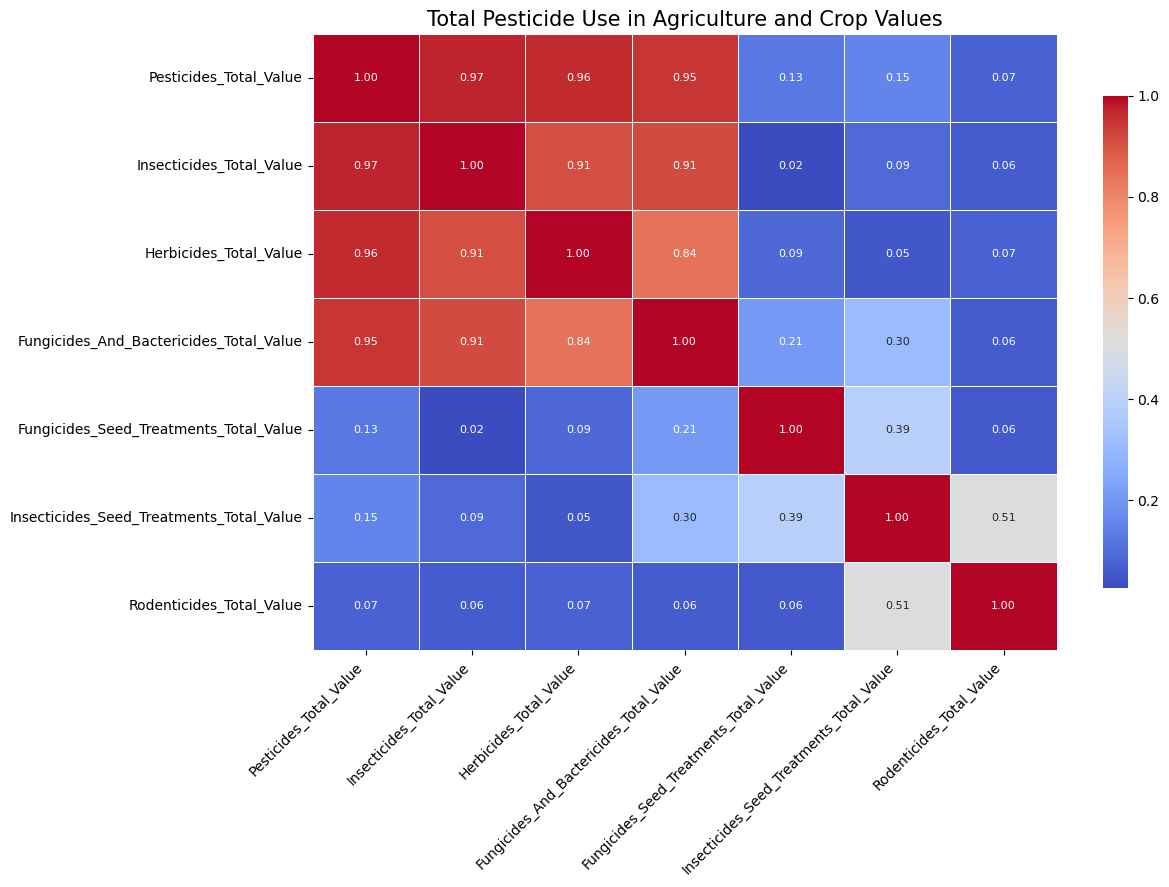

MSE: 10289080046306.41


,Feature,Importance
0,Pesticides_Total_Value,0.75
4,Fungicides_Seed_Treatments_Total_Value,0.06
3,Fungicides_And_Bactericides_Total_Value,0.06
2,Herbicides_Total_Value,0.05
6,Rodenticides_Total_Value,0.04
5,Insecticides_Seed_Treatments_Total_Value,0.02
1,Insecticides_Total_Value,0.02


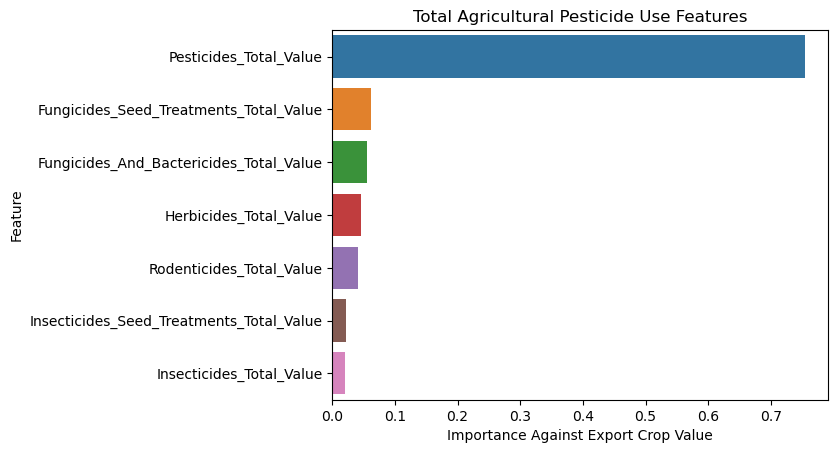

/var/folders/r7/pmx4mq9n359ff5rbmwjtfsqh0000gn/T/ipykernel_7568/16161967.py:28: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Item_x', 'Agricultural_Use_Element_x'} in the result is deprecated and will raise a MergeError in a future version.
  use_per_area_df = pd.merge(use_per_area_df, use_per_area_fungicides, on=['Area', 'Year'])
/var/folders/r7/pmx4mq9n359ff5rbmwjtfsqh0000gn/T/ipykernel_7568/16161967.py:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Item_x', 'Agricultural_Use_Element_x'} in the result is deprecated and will raise a MergeError in a future version.
  use_per_area_df = pd.merge(use_per_area_df, use_per_area_insecticides_seed_treatments, on=['Area', 'Year'])


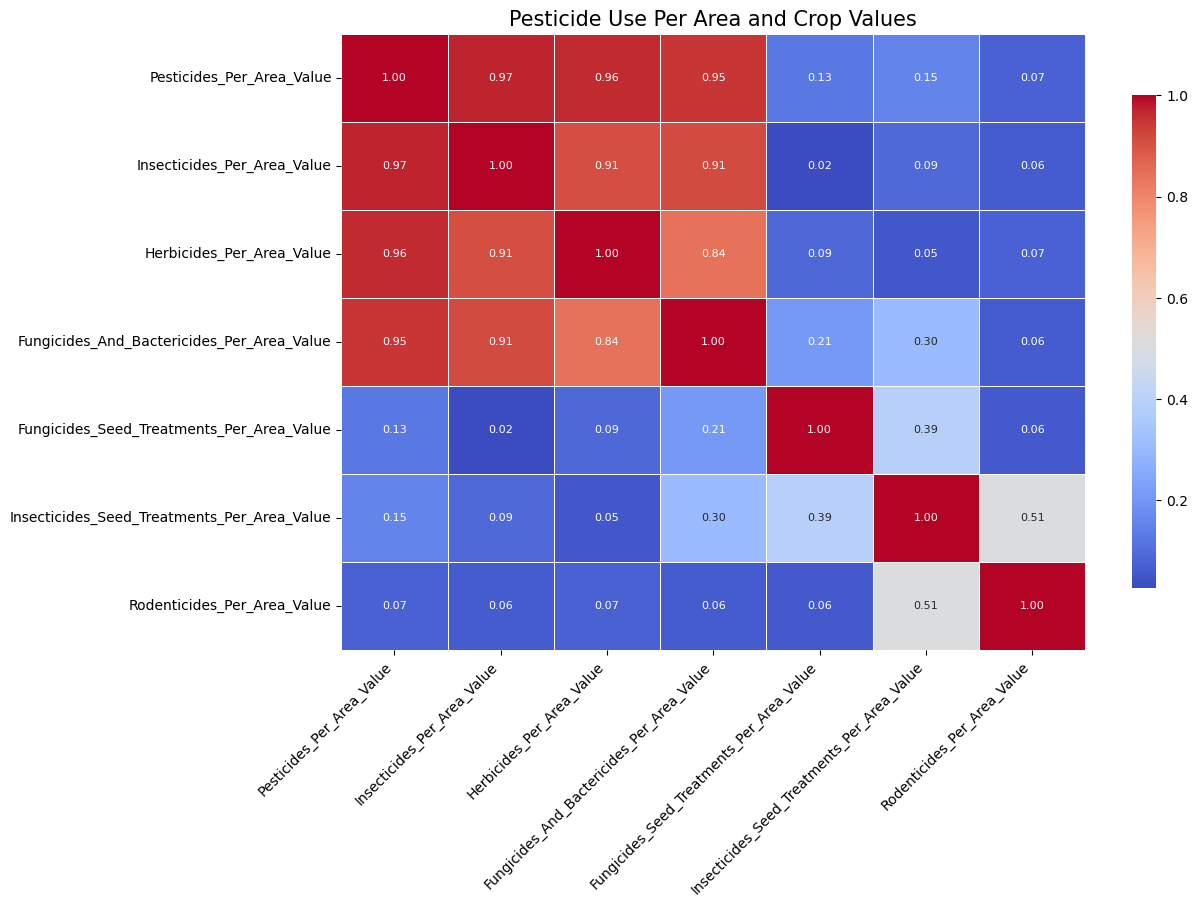

MSE: 5089702255999.957


,Feature,Importance
0,Pesticides_Per_Area_Value,0.71
3,Fungicides_And_Bactericides_Per_Area_Value,0.07
4,Fungicides_Seed_Treatments_Per_Area_Value,0.06
6,Rodenticides_Per_Area_Value,0.06
2,Herbicides_Per_Area_Value,0.05
1,Insecticides_Per_Area_Value,0.03
5,Insecticides_Seed_Treatments_Per_Area_Value,0.02


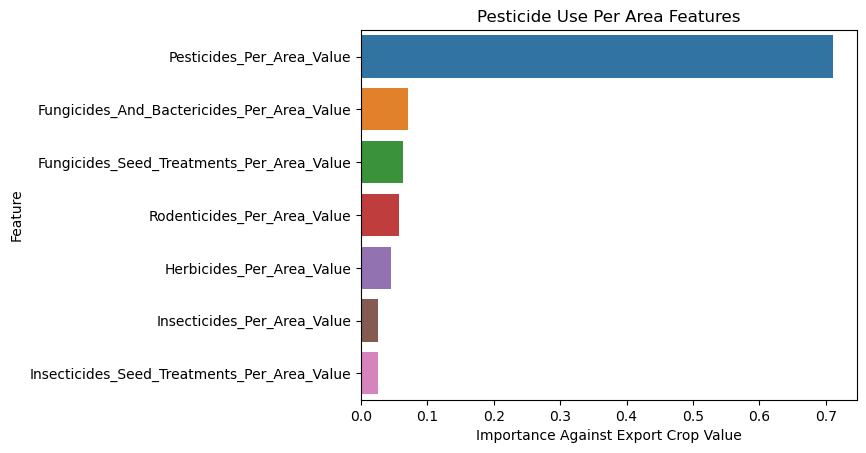

/var/folders/r7/pmx4mq9n359ff5rbmwjtfsqh0000gn/T/ipykernel_7568/16161967.py:53: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Item_x', 'Agricultural_Use_Element_x'} in the result is deprecated and will raise a MergeError in a future version.
  use_per_value_df = pd.merge(use_per_value_df, use_per_value_fungicides, on=['Area', 'Year'])
/var/folders/r7/pmx4mq9n359ff5rbmwjtfsqh0000gn/T/ipykernel_7568/16161967.py:55: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Item_x', 'Agricultural_Use_Element_x'} in the result is deprecated and will raise a MergeError in a future version.
  use_per_value_df = pd.merge(use_per_value_df, use_per_value_insecticides_seed_treatments, on=['Area', 'Year'])


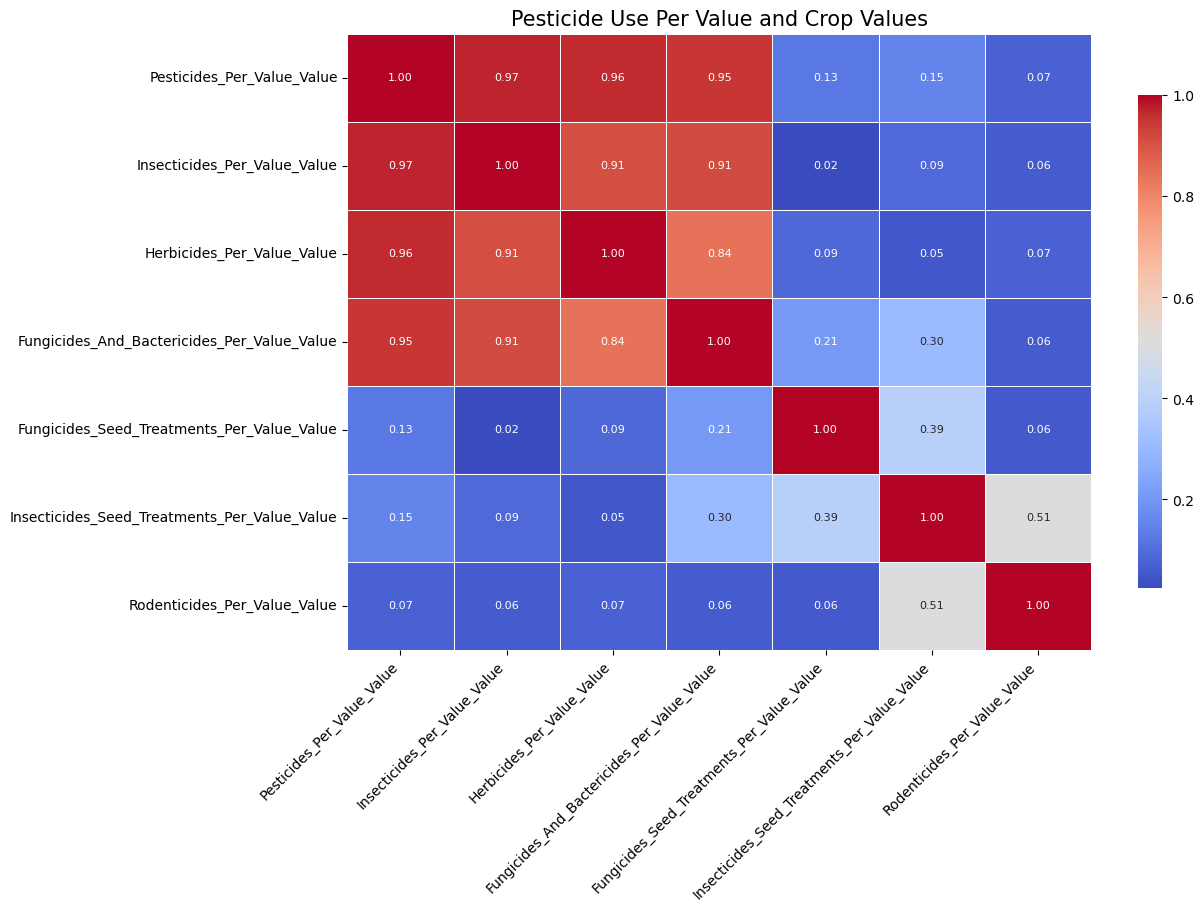

MSE: 16806007278082.742


,Feature,Importance
0,Pesticides_Per_Value_Value,0.76
4,Fungicides_Seed_Treatments_Per_Value_Value,0.07
3,Fungicides_And_Bactericides_Per_Value_Value,0.06
6,Rodenticides_Per_Value_Value,0.04
2,Herbicides_Per_Value_Value,0.04
1,Insecticides_Per_Value_Value,0.02
5,Insecticides_Seed_Treatments_Per_Value_Value,0.01


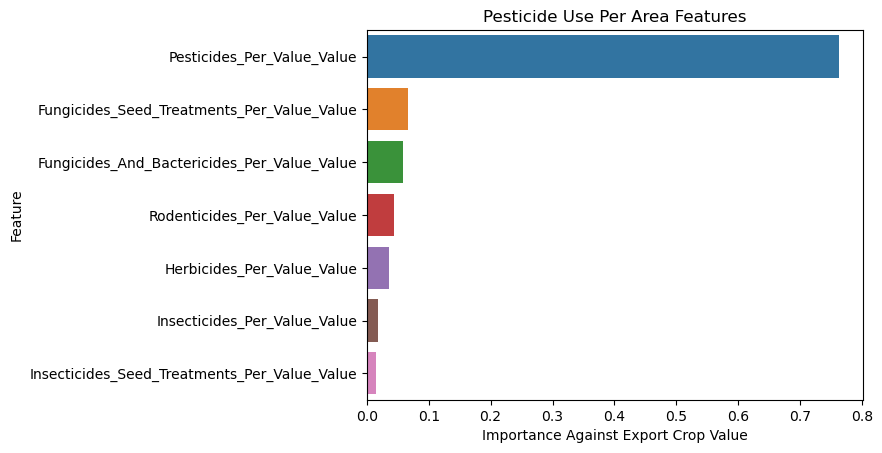

In [43]:
agr_use_df = pd.merge(agr_use_pesticides, agr_use_insecticides, on=['Area', 'Year'])
agr_use_df = pd.merge(agr_use_df, agr_use_herbicides, on=['Area', 'Year'])
agr_use_df = pd.merge(agr_use_df, agr_use_fungicides, on=['Area', 'Year'])
agr_use_df = pd.merge(agr_use_df, agr_use_fungicides_seed_treatments, on=['Area', 'Year'])
agr_use_df = pd.merge(agr_use_df, agr_use_insecticides_seed_treatments, on=['Area', 'Year'])
agr_use_df = pd.merge(agr_use_df, agr_use_rodenticides, on=['Area', 'Year'])
agr_use_df = pd.merge(agr_use_df, crop_exports_summed[['Area', 'Year', 'Annual_Crop_Export_Value']], on=['Area', 'Year'])

agr_use_cols = ['Pesticides_Total_Value', 'Insecticides_Total_Value', 'Herbicides_Total_Value', 
                'Fungicides_And_Bactericides_Total_Value', 'Fungicides_Seed_Treatments_Total_Value', 
                'Insecticides_Seed_Treatments_Total_Value', 'Rodenticides_Total_Value']
agr_use_scaler = StandardScaler()
agr_use_df[agr_use_cols] = agr_use_scaler.fit_transform(agr_use_df[agr_use_cols])
joblib.dump(agr_use_scaler, 'Scalers/pesticide_agr_use_scaler.pkl')

# find linear correlation between features and crop export values
correlation = agr_use_df[agr_use_cols].corr()
display_heatmap(correlation, title='Total Pesticide Use in Agriculture and Crop Values')
# find non-linear correlation between features and crop export values
X = agr_use_df[['Pesticides_Total_Value', 'Insecticides_Total_Value', 'Herbicides_Total_Value', 
                'Fungicides_And_Bactericides_Total_Value', 'Fungicides_Seed_Treatments_Total_Value', 
                'Insecticides_Seed_Treatments_Total_Value', 'Rodenticides_Total_Value']]
y = agr_use_df['Annual_Crop_Export_Value']
rank_feature_importance(X, y, 'Total Agricultural Pesticide Use Features')

use_per_area_df = pd.merge(use_per_area_pesticides, use_per_area_insecticides, on=['Area', 'Year'])
use_per_area_df = pd.merge(use_per_area_df, use_per_area_herbicides, on=['Area', 'Year'])
use_per_area_df = pd.merge(use_per_area_df, use_per_area_fungicides, on=['Area', 'Year'])
use_per_area_df = pd.merge(use_per_area_df, use_per_area_fungicides_seed_treatments, on=['Area', 'Year'])
use_per_area_df = pd.merge(use_per_area_df, use_per_area_insecticides_seed_treatments, on=['Area', 'Year'])
use_per_area_df = pd.merge(use_per_area_df, use_per_area_rodenticides, on=['Area', 'Year'])
use_per_area_df = pd.merge(use_per_area_df, crop_exports_summed[['Area', 'Year', 'Annual_Crop_Export_Value']], on=['Area', 'Year'])

use_per_area_cols = ['Pesticides_Per_Area_Value', 'Insecticides_Per_Area_Value', 'Herbicides_Per_Area_Value', 
                'Fungicides_And_Bactericides_Per_Area_Value', 'Fungicides_Seed_Treatments_Per_Area_Value', 
                'Insecticides_Seed_Treatments_Per_Area_Value', 'Rodenticides_Per_Area_Value']
use_per_area_scaler = StandardScaler()
use_per_area_df[use_per_area_cols] = use_per_area_scaler.fit_transform(use_per_area_df[use_per_area_cols])
joblib.dump(use_per_area_scaler, 'Scalers/pesticide_use_per_area_scaler.pkl')

# find linear correlation between features and crop export values
correlation = use_per_area_df[use_per_area_cols].corr()
display_heatmap(correlation, title='Pesticide Use Per Area and Crop Values')
# find non-linear correlation between features and crop export values
X = use_per_area_df[['Pesticides_Per_Area_Value', 'Insecticides_Per_Area_Value', 'Herbicides_Per_Area_Value', 
                'Fungicides_And_Bactericides_Per_Area_Value', 'Fungicides_Seed_Treatments_Per_Area_Value', 
                'Insecticides_Seed_Treatments_Per_Area_Value', 'Rodenticides_Per_Area_Value']]
y = use_per_area_df['Annual_Crop_Export_Value']
rank_feature_importance(X, y, 'Pesticide Use Per Area Features')

use_per_value_df = pd.merge(use_per_value_pesticides, use_per_value_insecticides, on=['Area', 'Year'])
use_per_value_df = pd.merge(use_per_value_df, use_per_value_herbicides, on=['Area', 'Year'])
use_per_value_df = pd.merge(use_per_value_df, use_per_value_fungicides, on=['Area', 'Year'])
use_per_value_df = pd.merge(use_per_value_df, use_per_value_fungicides_seed_treatments, on=['Area', 'Year'])
use_per_value_df = pd.merge(use_per_value_df, use_per_value_insecticides_seed_treatments, on=['Area', 'Year'])
use_per_value_df = pd.merge(use_per_value_df, use_per_value_rodenticides, on=['Area', 'Year'])
use_per_value_df = pd.merge(use_per_value_df, crop_exports_summed[['Area', 'Year', 'Annual_Crop_Export_Value']], on=['Area', 'Year'])

# normalise
use_per_value_cols = ['Pesticides_Per_Value_Value', 'Insecticides_Per_Value_Value', 'Herbicides_Per_Value_Value', 
                'Fungicides_And_Bactericides_Per_Value_Value', 'Fungicides_Seed_Treatments_Per_Value_Value', 
                'Insecticides_Seed_Treatments_Per_Value_Value', 'Rodenticides_Per_Value_Value']
use_per_value_scaler = StandardScaler()
use_per_value_df[use_per_value_cols] = use_per_value_scaler.fit_transform(use_per_value_df[use_per_value_cols])
joblib.dump(use_per_value_scaler, 'Scalers/use_per_value_scaler.pkl')

# find linear correlation between features and crop export values
correlation = use_per_value_df[use_per_value_cols].corr()
display_heatmap(correlation, title='Pesticide Use Per Value and Crop Values')
# find non-linear correlation between features and crop export values
X = use_per_value_df[['Pesticides_Per_Value_Value', 'Insecticides_Per_Value_Value', 'Herbicides_Per_Value_Value', 
                'Fungicides_And_Bactericides_Per_Value_Value', 'Fungicides_Seed_Treatments_Per_Value_Value', 
                'Insecticides_Seed_Treatments_Per_Value_Value', 'Rodenticides_Per_Value_Value']]
y = use_per_value_df['Annual_Crop_Export_Value']
rank_feature_importance(X, y, 'Pesticide Use Per Area Features')

## Select and Save Features





In [44]:
# * emissions.csv
save_feature(n20_emissions, 'n20_emissions')

# * consumer_prices.csv
save_feature(price_inflation, 'food_price_inflation_value')

# * crops_production_indicators.csv
# high non-linear correlation. Only saving items with >20%
save_feature(sugars, 'sugar_production_production_indicators')
save_feature(fruit_and_veg, 'fruit_and_veg_production_indicator')

# * emissions.csv
save_feature(employment_estimates, 'employment_estimates')

# * exchange_rate.csv
save_feature(exchange_rates, 'exchange_rates')

# * features from fertilizers.csv
# non-linearly correlated features
save_feature(amm_sulphate, 'ammonium_sulphate_fertiliser')
save_feature(sop, 'SOP_fertiliser')
save_feature(can, 'CAN_fertiliser')

# linearly correlated features
save_feature(an, 'ammounium_nitrate_fertiliser')
save_feature(map, 'MAP_fertiliser')
save_feature(mop, 'MOP_fertiliser')
save_feature(other_np, 'other_np_compounds_fertiliser')
save_feature(pot_nitrate, 'potassium_nitrate_fertiliser')
save_feature(an, 'ammounium_nitrate_fertiliser')
save_feature(sod_nitrate, 'sodium_nitrate_fertiliser')
save_feature(superphosphates_35, 'superphosphates_above_35_pct_fertiliser')
save_feature(superphosphates_other, 'superphosphates_other_fertiliser')


# * features from food_balance_indicators.csv
# non-linear features
save_feature(roots_imports, 'roots_imports_balance_indicator')
save_feature(fruits_imports, 'fruits_imports_balance_indicator')
save_feature(vegetable_oils_exports, 'vegetable_oils_exports_balance_indicator')
save_feature(vegetable_oils_losses, 'vegetable_oils_losses_balance_indicator')
save_feature(vegetable_oils_other, 'vegetable_oils_other_balance_indicator')
save_feature(cereal_other, 'cereal_other_balance_indicator')
save_feature(alcohol_food, 'alcohol_food_balance_indicator')

# linear features
save_feature(cereal_imports, 'cereal_imports_balance_indicator')
save_feature(vegetable_oils_imports, 'vegetable_oils_imports_balance_indicator')
save_feature(alcohol_imports, 'alcohol_imports_balance_indicator')
save_feature(cereal_exports, 'cereal_exports_balance_indicator')
save_feature(oil_crops_exports, 'oil_crops_exports_balance_indicator')
save_feature(fruits_exports, 'fruits_exports_balance_indicator')
save_feature(alcohol_exports, 'alcohol_exports_balance_indicator')
save_feature(cereal_losses, 'cereal_losses_balance_indicator')
save_feature(sugars_losses, 'sugars_losses_balance_indicator')
save_feature(oil_crops_losses, 'oil_crops_losses_balance_indicator')
save_feature(fruits_losses, 'fruits_losses_balance_indicator')
save_feature(alcohol_losses, 'alcohol_losses_balance_indicator')
save_feature(roots_other, 'roots_other_balance_indicator')
save_feature(sugars_other, 'sugars_other_balance_indicator')
save_feature(oil_crops_other, 'oil_crops_other_balance_indicator')
save_feature(cereal_food, 'cereal_food_balance_indicator')
save_feature(roots_food, 'roots_food_balance_indicator')
save_feature(oil_crops_food, 'oil_crops_food_balance_indicator')
save_feature(vegetable_oils_food, 'vegetable_oils_food_balance_indicator')
save_feature(fruits_food, 'fruits_food_balance_indicator')

# * feature from food_security_indicator.csv
save_feature(low_birthweight, 'low_birthweight_prevalence')

# * features from foreign_direct_investment.csv
# fbt inflow both outflow

# FDI inflows to Food, Beverages and Tobacco
# FDI outflows to Agriculture, Forestry and Fishing

save_feature(fbt_inflow, 'fdi_fbt_inflow')
save_feature(fbt_outflow, 'fdi_fbt_outflow')
save_feature(aff_outflow, 'fdi_aff_outflow')

# * feature from land_temperature_change.csv
save_feature(std_dev, 'std_dev_of_land_temp_change')

# * features from land_use.csv
save_feature(country_area, 'country_area_land_use') 
save_feature(land_area, 'land_area_land_use')
save_feature(agriculture, 'agriculture_land_use')
save_feature(agricultural_land, 'agricultural_land_land_use')
save_feature(cropland, 'cropland_land_use')
save_feature(arable_land, 'arable_land_land_use')
save_feature(temporary_crops, 'temporary_crops_land_use')
save_feature(temp_meadows, 'temporary_meadows_land_use')
save_feature(temp_fallow, 'temporary_fallow_land_use')
save_feature(permanent_crops, 'permanent_crops_land_use')
save_feature(permanent_meadows, 'permanent_meadows_land_use')
save_feature(nat_perm_meadows, 'natural_permanent_meadows_land_use')
save_feature(land_equipped_irr, 'land_equipped_with_irrigation_land_use')
save_feature(irrigated_land, 'irrigated_land_land_use')
save_feature(agricultural_land_irr, 'agricultural_land_irrigated_land_use')
save_feature(farm_buildings, 'farms_land_use')
save_feature(irrigated_crop_land, 'irrigated_crop_land_land_use')
save_feature(permanent_meadows_irr, 'permanent_meadows_irrigated_land_use')
# all except irrigated forestry

# * features from pesticides.csv
save_feature(agr_use_pesticides, 'total_pesticides_in_agriculture')
save_feature(use_per_area_pesticides, 'pesticide_use_per_area')
save_feature(use_per_value_pesticides, 'pesticide_use_per_value')

# Create Features and Labels

Loads and merges all selected features into one large DataFrame. Performs an outer join so information is retained in its appropriate format even when merging with a smaller or larger DataFrame. The value for each DataFrame is normalised against `Annual_Crop_Export_Value` before it is merged. This ensures all data points are in the right scale and grouped together. 

A sentinel value of -999 is used as a special token. The model will not update parameters when it sees this value. This allows a full run through all of the data without any biases being introduced from gaps in the data.

In [45]:
features_dir = glob.glob(os.path.join('Data/selected_features/', '*.csv'))

features_df = pd.DataFrame(columns=['Area', 'Year'])
# Inspect csv files before selecting features
for path in features_dir:
    df = pd.read_csv(path)
    value_cols = [col for col in df.columns if '_Value' in col]
    value_cols = value_cols + ['Area', 'Year']
    df= df.drop(columns=[col for col in df.columns if col not in value_cols])
    features_df = pd.merge(features_df, df, on=['Area', 'Year'], how='outer')

total_dataset = pd.merge(features_df, crop_exports_summed[['Year', 'Area', 'Annual_Crop_Export_Value']], on=['Year', 'Area'], how='inner')
total_dataset = total_dataset.rename(columns={'Annual_Crop_Export_Value': 'Labels'})

# allows a model to ignore null features during backpropagation
SENTINEL_VALUE = -999
total_dataset = total_dataset.fillna(SENTINEL_VALUE)

In [46]:
display(total_dataset)

,Area,Year,Birthweight_Value,Vegetable_Oils_Imports_Value,Vegetable_Oils_Exports_Value,Nat_Perm_Meadows_And_Pastures_Value,Irrigated_Crop_Land_Value,Country_Area_Value,Cropland_Value,CAN_Value,...,Permanent_Crops_Value,Irrigated_Land_Value,Oil_Crops_Exports_Value,Potassium_Nitrate_Value,Vegetable_Oils_Losses_Value,Pesticides_Per_Value_Value,Vegetable_Oils_Food_Value,Total_FBT_Inflow_Value,Fruits_Food_Value,Labels
0,Afghanistan,2002,35.40,-999.00,-999.00,30000.00,-999.00,65286.00,7790.00,-999.00,...,112.00,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,34952.00
1,Afghanistan,2002,35.40,-999.00,-999.00,30000.00,-999.00,65286.00,7790.00,-999.00,...,112.00,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,34952.00
2,Afghanistan,2002,35.40,-999.00,-999.00,30000.00,-999.00,65286.00,7790.00,-999.00,...,112.00,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,34952.00
3,Afghanistan,2002,35.40,-999.00,-999.00,30000.00,-999.00,65286.00,7790.00,-999.00,...,112.00,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,34952.00
4,Afghanistan,2002,35.40,-999.00,-999.00,30000.00,-999.00,65286.00,7790.00,-999.00,...,112.00,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,34952.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38220,Zimbabwe,2022,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,...,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,2170101.47
38221,Zimbabwe,2022,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,...,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,2170101.47
38222,Zimbabwe,2022,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,...,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,2170101.47
38223,Zimbabwe,2022,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,...,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,2170101.47


# Create Custom Functions

In [47]:
class CustomMSE(nn.Module):
    def __init__(self, sentinel_value):
        super(CustomMSE, self).__init__()
        self.sentinel_value = sentinel_value

    def forward(self, labels, features):
        """
        
        """
        mask = features != self.sentinel_value
        masked_labels = labels[mask]
        masked_features = features[mask]
        mse = nn.functional.mse_loss(masked_features, masked_labels)
        return mse

class ShiftLabelsDataset(Dataset):
    """
    Dataset for model to learn relationships between
    shifted features and labels 
    """
    def __init__(self, dataset, shift):
        # shift labels by 3 years so the model infers relationships between
        # the current features and the label 3 years into the future
        self.shift = shift
        dataset['Shifted_Labels'] = dataset['Labels'].shift(self.shift)
        dataset = dataset.dropna().reset_index(drop=True)
        features = dataset.drop(columns=['Labels', 'Shifted_Labels'])
        self.data: pd.DataFrame = features.filter(regex='_Value')
        self.labels = dataset['Shifted_Labels']
    
    def __getitem__(self, idx):
        label = self.labels.iloc[idx]
        data = self.data.iloc[idx]

        label = torch.tensor([label], dtype=torch.float32)
        data = torch.tensor(data, dtype=torch.float32)
        return label, data
    
    def __len__(self):
        return len(self.data)

# Define Model

In [121]:
class CropExportValueForecastMLP(nn.Module):
    def __init__(self, input_size: int, feature_data: pd.DataFrame):
        super(CropExportValueForecastMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 96),
            nn.Linear(96, 156),
            nn.Linear(156, 312),
            nn.Linear(312, 428),
            nn.Linear(428, 512),
            nn.Linear(512, 286),
            nn.Linear(286, 128),
            nn.Linear(128, 32),
            nn.Linear(32, 1),
            nn.ReLU()
        )
        # Used to find historical data if making predictions
        self.features = feature_data
        self.trained = False
    
    def forward(self, x):
        return self.model(x)
    
    def run_training(self, train_loader, val_loader, test_loader, criterion, optimizer, scheduler, num_epochs):
        train_mse, train_mae, train_r2, val_mse, val_mae, val_r2 = self.__train(train_loader, 
                                                                                val_loader, 
                                                                                criterion, 
                                                                                optimizer,
                                                                                scheduler,
                                                                                num_epochs)
        test_mse, test_mae, test_r2 = self.__test(test_loader, criterion)
        self.__plot_metrics(train_mse, val_mse, test_mse, 
                            train_mae, val_mae, test_mae, 
                            train_r2, val_r2, test_r2)
        self.trained = True
    
    def predict(self, country, year, show_label=False):
        if not self.trained:
            raise ModelNotTrainedError

        years = self.features['Year'].drop_duplicates().sort_values()
        start_year = years.min()
        end_year = years.max()
        
        if year < start_year:
            raise ValueError(f'Cannot predict earlier than {start_year} for {country.title()}.\nAvailable years: {years}')
        if year > end_year:
            raise ValueError(f'Cannot predict later than {end_year - 3} for {country.title()}.\nAvailable years: {years}')

        feature_tensor = self.__feature_tensor(country, year, start_year)
        
        self.eval()
        with torch.no_grad():
            prediction = self.forward(feature_tensor).item()
        
        print(f'{country.title()} {year}')
        print(f'Predicted {year + 3} crop export value: ${prediction}.')
        if show_label:
            label = self.features.loc[(self.features['Year'] == year) & (self.features['Area'] == country), 'Labels'].values[0]
            print(f'Actual {year + 3} crop export value: ${label}.')
        print('Unit: $1000 USD.')
    
    def __feature_tensor(self, country, year, start_year):
        years = list(range(start_year, year - 2))

        data = self.features.loc[(self.features['Area'] == country) & (self.features['Year'].isin(years))]
        display(data)
        if not self.__exists_data(data):
            raise ValueError(f'Not enough data from {year} to make a prediction '
                             f'for {country} in {year + 3}.') 
        
        data = data.filter(regex='_Value')
        data = data.replace(-999, np.nan)
        data = data.mean().fillna(-999)
        data_array = data.to_numpy()
        data_tensor = torch.tensor(data_array, dtype=torch.float32)
        data_tensor = data_tensor.unsqueeze(0)
                
        return data_tensor
        
    def __exists_data(self, data):
        """
        Ensures there's enough data to make a prediction
        """
        data_exists = False
        for col in data:
            if not(data[col] == -999).all():
                data_exists = True
                break
        return data_exists
    
    def __train(self, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs):
        train_epoch_mse = []
        train_epoch_mae = []
        train_epoch_r2 = []
        val_epoch_mse = []
        val_epoch_mae = []
        val_epoch_r2 = []
        for epoch in range(num_epochs):
            print(f'Epoch {epoch + 1}/{num_epochs}')
            self.train()
            train_preds = []
            train_labels = []
            train_running_loss = 0.0
            for labels, features in train_loader:
                optimizer.zero_grad()
                predictions = self(features)
                loss = criterion(predictions.squeeze(), labels.squeeze())
                loss.backward()
                optimizer.step()
                train_running_loss += loss.item() * features.size(0)
                # Handle single-element batches
                if predictions.numel() == 1:
                    train_preds.append(predictions.item())
                    train_labels.append(labels.item())
                else:
                    train_preds.extend(predictions.squeeze().tolist())
                    train_labels.extend(labels.squeeze().tolist())
            epoch_train_mse = train_running_loss / len(train_loader.dataset)
            mae = mean_absolute_error(train_labels, train_preds)
            r2 = r2_score(train_labels, train_preds)
            print(f'Training MSE: {epoch_train_mse:.4f}')
            train_epoch_mse.append(epoch_train_mse)
            train_epoch_mae.append(mae)
            train_epoch_r2.append(r2)
            
            self.eval()
            val_preds = []
            val_labels = []
            val_running_loss = 0.0
            with torch.no_grad():
                for labels, features in val_loader:
                    predictions = self.forward(features)
                    loss = criterion(predictions.squeeze(), labels.squeeze())
                    val_running_loss += loss.item() * features.size(0)
                    val_preds.extend(predictions.squeeze().tolist())
                    val_labels.extend(labels.squeeze().tolist())
            scheduler.step()
            epoch_val_mse = val_running_loss / len(val_loader.dataset)
            mae = mean_absolute_error(val_labels, val_preds)
            r2 = r2_score(val_labels, val_preds)
            val_epoch_mse.append(epoch_val_mse)
            val_epoch_mae.append(mae)
            val_epoch_r2.append(r2)
            print(f'Validation MSE: {epoch_val_mse:.4f}')
            print(f'Validation MAE: {mae:.4f}')
            print(f'Validation R² : {r2:.4f}')
            print()
        return train_epoch_mse, train_epoch_mae, train_epoch_r2, \
            val_epoch_mse, val_epoch_mae, val_epoch_r2

    
    def __test(self, test_loader, criterion):
        self.eval()
        test_preds = []
        test_labels = []
        test_running_loss = 0.0
        with torch.no_grad():
            for labels, features in test_loader:
                predictions = self.forward(features)
                loss = criterion(predictions.squeeze(), labels.squeeze())
                test_running_loss += loss.item() * features.size(0)
                # Handle single-element batches
                if predictions.numel() == 1:
                    test_preds.append(predictions.item())
                    test_labels.append(labels.item())
                else:
                    test_preds.extend(predictions.squeeze().tolist())
                    test_labels.extend(labels.squeeze().tolist())
        epoch_test_mse = test_running_loss / len(test_loader.dataset)
        mae = mean_absolute_error(test_labels, test_preds)
        r2 = r2_score(test_labels, test_preds)
        print(f'Test MSE: {epoch_test_mse:.4f}')
        print(f'Test MAE: {mae:.4f}')
        print(f'Test R² : {r2:.4f}')
        return epoch_test_mse, mae, r2

    def __plot_metrics(self, train_mse, val_mse, test_mse, 
                       train_mae, val_mae, test_mae, 
                       train_r2, val_r2, test_r2):
        epochs = range(1, len(train_mse) + 1)
        
        plt.figure(figsize=(18, 5))
        
        # Plot MSE
        plt.subplot(1, 3, 1)
        plt.plot(epochs, train_mse, label='Training')
        plt.plot(epochs, val_mse, label='Validation')
        plt.axhline(test_mse, color='r', linestyle='--', label='Test')
        plt.xlabel('Epochs')
        plt.ylabel('MSE')
        plt.legend()
        plt.title('Mean Squared Error')
        
        # Plot MAE
        plt.subplot(1, 3, 2)
        plt.plot(epochs, train_mae, label='Training')
        plt.plot(epochs, val_mae, label='Validation')
        plt.axhline(test_mae, color='r', linestyle='--', label='Test')
        plt.xlabel('Epochs')
        plt.ylabel('MAE')
        plt.legend()
        plt.title('Mean Absolute Error')
        
        # Plot R²
        plt.subplot(1, 3, 3)
        plt.plot(epochs, train_r2, label='Training')
        plt.plot(epochs, val_r2, label='Validation')
        plt.axhline(test_r2, color='r', linestyle='--', label='Test')
        plt.xlabel('Epochs')
        plt.ylabel('R²')
        plt.legend()
        plt.title('R²')
        
        plt.tight_layout()
        plt.show()
        
class ModelNotTrainedError(Exception):
    def __init__(self):
        self.message = 'The model must be trained before making predictions.'
        super().__init__(self.message)

Epoch 1/2
Training MSE: 166048735615305.0000
Validation MSE: 168550889747423.5625
Validation MAE: 7084801.9290
Validation R² : -0.0467

Epoch 2/2
Training MSE: 155477383834119.7812
Validation MSE: 168528783594096.9688
Validation MAE: 7117263.8005
Validation R² : -0.0465

Test MSE: 154473392123115.9375
Test MAE: 6861153.1066
Test R² : -0.0394


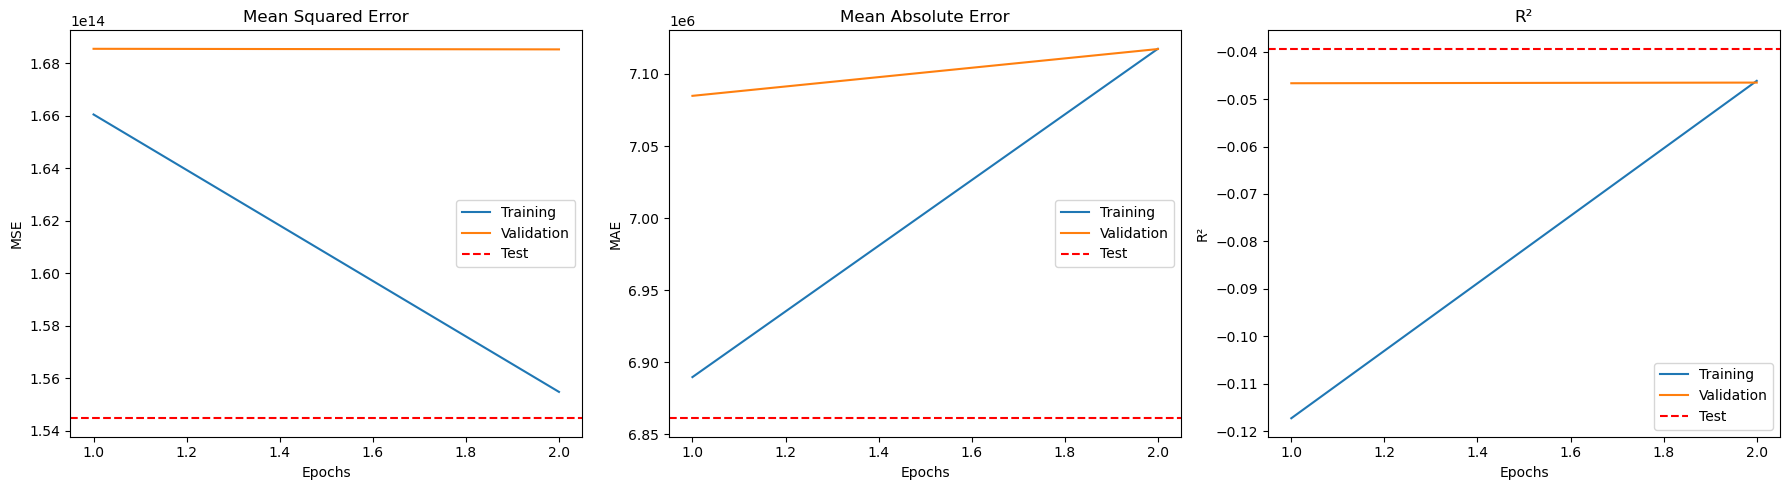

In [122]:
train, test = train_test_split(total_dataset, test_size=0.2)
train, val = train_test_split(train, test_size=0.25)

shift= -3
train_set = ShiftLabelsDataset(train, shift)
val_set = ShiftLabelsDataset(val, shift)
test_set = ShiftLabelsDataset(test, shift)

batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False)

lr = 0.001
criterion = CustomMSE(SENTINEL_VALUE)

model = CropExportValueForecastMLP(69, total_dataset)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10)

num_epochs = 2
model.run_training(train_loader, val_loader, test_loader, criterion, optimizer, scheduler, num_epochs)

In [123]:
model.predict('Cyprus', 2007, show_label=True)

,Area,Year,Birthweight_Value,Vegetable_Oils_Imports_Value,Vegetable_Oils_Exports_Value,Nat_Perm_Meadows_And_Pastures_Value,Irrigated_Crop_Land_Value,Country_Area_Value,Cropland_Value,CAN_Value,...,Permanent_Crops_Value,Irrigated_Land_Value,Oil_Crops_Exports_Value,Potassium_Nitrate_Value,Vegetable_Oils_Losses_Value,Pesticides_Per_Value_Value,Vegetable_Oils_Food_Value,Total_FBT_Inflow_Value,Fruits_Food_Value,Labels
7095,Cyprus,2002,12.10,-999.00,-999.00,-999.00,35.00,925.00,139.00,146.00,...,39.00,-999.00,-999.00,1.00,-999.00,1060.57,-999.00,20.23,-999.00,314041.00
7096,Cyprus,2002,12.10,-999.00,-999.00,-999.00,35.00,925.00,139.00,146.00,...,39.00,-999.00,-999.00,1.00,-999.00,1060.57,-999.00,20.23,-999.00,314041.00
7097,Cyprus,2002,12.10,-999.00,-999.00,-999.00,35.00,925.00,139.00,146.00,...,39.00,-999.00,-999.00,1.00,-999.00,1060.57,-999.00,20.23,-999.00,314041.00
7098,Cyprus,2002,12.10,-999.00,-999.00,-999.00,35.00,925.00,139.00,146.00,...,39.00,-999.00,-999.00,1.00,-999.00,1060.57,-999.00,20.23,-999.00,314041.00
7099,Cyprus,2002,12.10,-999.00,-999.00,-999.00,35.00,925.00,139.00,146.00,...,39.00,-999.00,-999.00,1.00,-999.00,1060.57,-999.00,20.23,-999.00,314041.00
7100,Cyprus,2003,12.00,-999.00,-999.00,-999.00,36.00,925.00,153.00,106.00,...,41.00,-999.00,-999.00,3.00,-999.00,796.43,-999.00,0.42,-999.00,294141.00
7101,Cyprus,2003,12.00,-999.00,-999.00,-999.00,36.00,925.00,153.00,106.00,...,41.00,-999.00,-999.00,3.00,-999.00,796.43,-999.00,0.42,-999.00,294141.00
7102,Cyprus,2003,12.00,-999.00,-999.00,-999.00,36.00,925.00,153.00,106.00,...,41.00,-999.00,-999.00,3.00,-999.00,796.43,-999.00,0.42,-999.00,294141.00
7103,Cyprus,2003,12.00,-999.00,-999.00,-999.00,36.00,925.00,153.00,106.00,...,41.00,-999.00,-999.00,3.00,-999.00,796.43,-999.00,0.42,-999.00,294141.00
7104,Cyprus,2003,12.00,-999.00,-999.00,-999.00,36.00,925.00,153.00,106.00,...,41.00,-999.00,-999.00,3.00,-999.00,796.43,-999.00,0.42,-999.00,294141.00


Cyprus 2007
Predicted 2010 crop export value: $3990080.0.
Actual 2010 crop export value: $206953.0.
Unit: $1000 USD.
